Part 2 of this notebook will focus on Feature Extraction & building machine learning models, using the data cleaned on Part 1 of the notebook, for NBA MVP Prediction.

### Notebook Preparation

In [1]:
## Import Packages ##

# Python libaries
import pandas as pd
import numpy as np
import random as python_random

#For Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce

# Sklearn Packages
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import r2_score

# XGBooks Packages
from xgboost import XGBRegressor
from xgboost import XGBClassifier

# Neural Networks
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from keras.wrappers.scikit_learn import KerasRegressor

# Import shap for feature importance
import shap

import warnings
warnings.filterwarnings("ignore")

/Users/husseinwarfa/opt/anaconda3/envs/Warfa2/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# Extract notebook from Part 1
df_model = pd.read_csv('data/df_model2.csv')

In [3]:
# Define Model constants
random_state_val = 123

# Develop a function to ensure model results are reproduceable
def reset_seeds():
    
    # Set the numpy pseudo-random generator at a fixed value
    np.random.seed(random_state_val)
    
    # Set the python built-in pseudo-random generator at a fixed value
    python_random.seed(random_state_val)
    
    # Set the `tensorflow` pseudo-random generator at a fixed value
    tf.random.set_seed(random_state_val)

reset_seeds()

### **Table of Contents** <a id="1.1"></a>
* [1. Feature Engineering](#1)
   * [1.1 Independent Variable (Numerical)](#1.1)
   * [1.2 Independent Variable (Categorical) ](#1.2)
   * [1.3 Dependent Variable ](#1.3)

* [2. Modeling](#2)
   * [2.1 XGBoost / Random Forest Pipeline Regressors](#2.1)
   * [2.2 XGBoost / Random Forest Pipeline Classifiers](#2.2)
      * [2.2.1 Classification Model (Original Dataset)](#2.2.1)   
      * [2.2.2 Classification Model (Upsampled Dataset)](#2.2.2)   
   * [2.3 Keras Regressor](#2.3)
   * [2.4 Keras Classifier](#2.4)
      
* [3. Scikit Learn / Neural Network Model Results & Summary](#3)
   * [3.1 Regression Models Predictions](#3.1)   
   * [3.2 Classification Models Predictions](#3.2)   

* [4. Feature Importance](#4)

* [5. Conclusion](#5)

## Feature Engineering <a id="1"></a>

We have a lot of features and columns to process in this project. There are several numerical columns that are correlated based where they provide similar information i.e FG (field goals) FG% (field goal percentage). Therefore, we would only explore the percentage columns as it provides a normalized value. <br>

But first, lets re-check if there are any nulls and duplicated rows.

In [4]:
# Let us re-check if there are any nulls present
df_model.isnull().sum().any()

False

In [5]:
# Re-checking for Duplicates
# Columns
print(f'Duplicated columns: {df_model.T.duplicated().any()}')
# Rows
print(f'Duplicated rows: {df_model.duplicated().any()}')

Duplicated columns: False
Duplicated rows: False


### Independent Variables (Numerical) <a id="1.1"></a>

In [6]:
# Select numeric variables 
df_numeric = df_model.select_dtypes(['float64','int64'])

# Filter out target variable and correlated variables
df_numeric.drop(columns=['Year', 'Rank', 'First', 'Pts Won', 'Pts Max','Share'], inplace=True)

In [7]:
# summary statistics
df_numeric.describe()

Age             G            MP           PER           TS%  \
count  18243.000000  18243.000000  18243.000000  18243.000000  18243.000000   
mean      26.629228     53.733980   1266.924848     12.784805      0.512726   
std        4.083790     25.309209    916.648357      6.113283      0.091148   
min       18.000000      1.000000      0.000000    -90.600000      0.000000   
25%       23.000000     35.000000    414.000000      9.900000      0.481000   
50%       26.000000     61.000000   1188.000000     12.900000      0.523000   
75%       29.000000     76.000000   2012.500000     15.900000      0.558000   
max       44.000000     85.000000   3533.000000    133.800000      1.500000   

               3PAr           FTr          ORB%          DRB%          TRB%  \
count  18243.000000  18243.000000  18243.000000  18243.000000  18243.000000   
mean       0.188682      0.309661      6.031382     14.038935     10.036244   
std        0.206789      0.214138      4.845100      6.519863      4.964947   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.007000      0.193000      2.500000      9.200000      6.100000   
50%        0.102000      0.279000      5.000000     13.100000      9.200000   
75%        0.338000      0.385000      8.800000     18.200000     13.400000   
max        1.000000      6.000000    100.000000    100.000000     86.400000   

       ...             W             L            PW            PL  \
count  ...  18243.000000  18243.000000  18243.000000  18243.000000   
mean   ...     39.793839     40.390670     39.876117     40.308392   
std    ...     12.775424     12.748206     12.297963     12.289292   
min    ...      7.000000      9.000000      7.000000     11.000000   
25%    ...     30.000000     31.000000     31.000000     31.000000   
50%    ...     41.000000     40.000000     40.000000     40.000000   
75%    ...     50.000000     50.000000     49.000000     49.000000   
max    ...     73.000000     72.000000     70.000000     72.000000   

                MOV           SOS           SRS          ORtg          DRtg  \
count  18243.000000  18243.000000  18243.000000  18243.000000  18243.000000   
mean      -0.122249      0.005656     -0.116557    106.925341    107.039577   
std        4.679379      0.394753      4.518789      4.068726      3.777568   
min      -15.200000     -1.030000    -14.680000     92.200000     94.100000   
25%       -3.390000     -0.280000     -3.260000    104.200000    104.500000   
50%        0.160000      0.000000      0.070000    106.700000    107.200000   
75%        3.350000      0.300000      3.140000    109.700000    109.700000   
max       12.240000      1.170000     11.800000    118.300000    117.600000   

               NRtg  
count  18243.000000  
mean      -0.114236  
std        4.886269  
min      -15.200000  
25%       -3.500000  
50%        0.200000  
75%        3.500000  
max       13.400000  

[8 rows x 33 columns]

We have 33 features to explore which is quite sizeable. Let us inspect correlation between the variables and potentially eliminate variables that are correlated. 

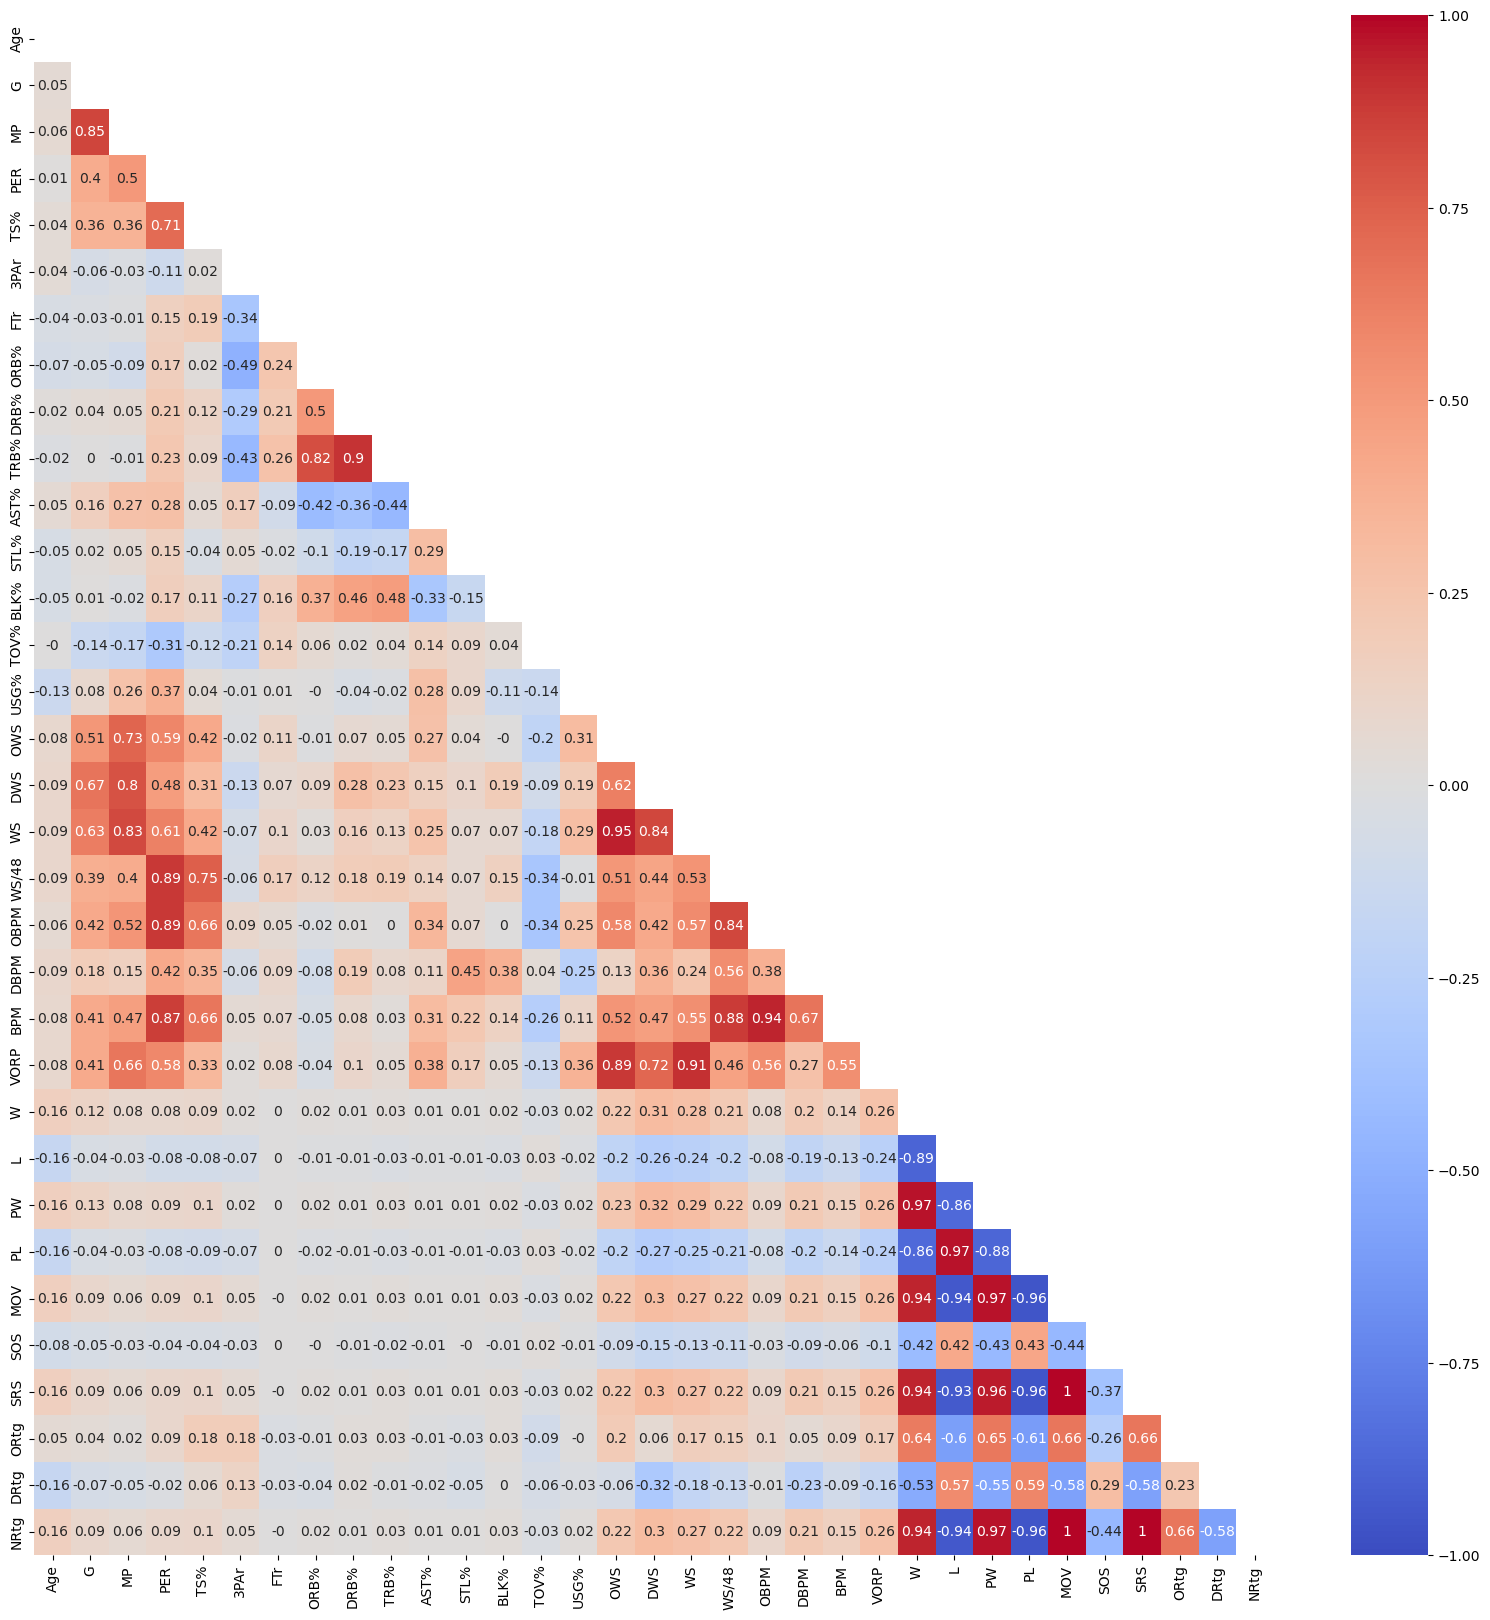

In [8]:
# Calculate all the correlations between each independent variable
corr_df = df_numeric.corr()

# Mask for upper-triangular
mask = np.triu(corr_df)

# Visualize with seaborn
plt.figure(figsize=(20, 20))
sns.heatmap(corr_df.round(2), annot=True, vmax=1, vmin=-1, center=0, cmap='coolwarm', mask=mask)
plt.show()

There are several features that are correlated. Additionally, some of the variables are redundant and provided similar information i.e 3P and 3P%. For our model, it would be beneficial to use scaled data so we will drop columns that are not scaled i.e 3P, 3PA.
- Drop G, but keep MP
- Drop TRB, but keep ORB and DRB
- Drop PW, PL, L, W but keep MOV
- Drop NRtg, but keep ORTg and DRTg 
- Drop SRS, but keep SOS

In [9]:
df_numeric.drop(columns=['G','TRB%','W','PW','PL','L','NRtg', 'SRS'],inplace=True)

We still have correlation between several features, so a linear regression model will not be ideal for this project as we would need to eliminate so many variables which will likely result in a low model accuracy. <br>

Given we have 24 features left, it still quite a number of variables to explore relationships further. Lets create plots to evaluate relationships/trends between the 9 key individual player statistics. 

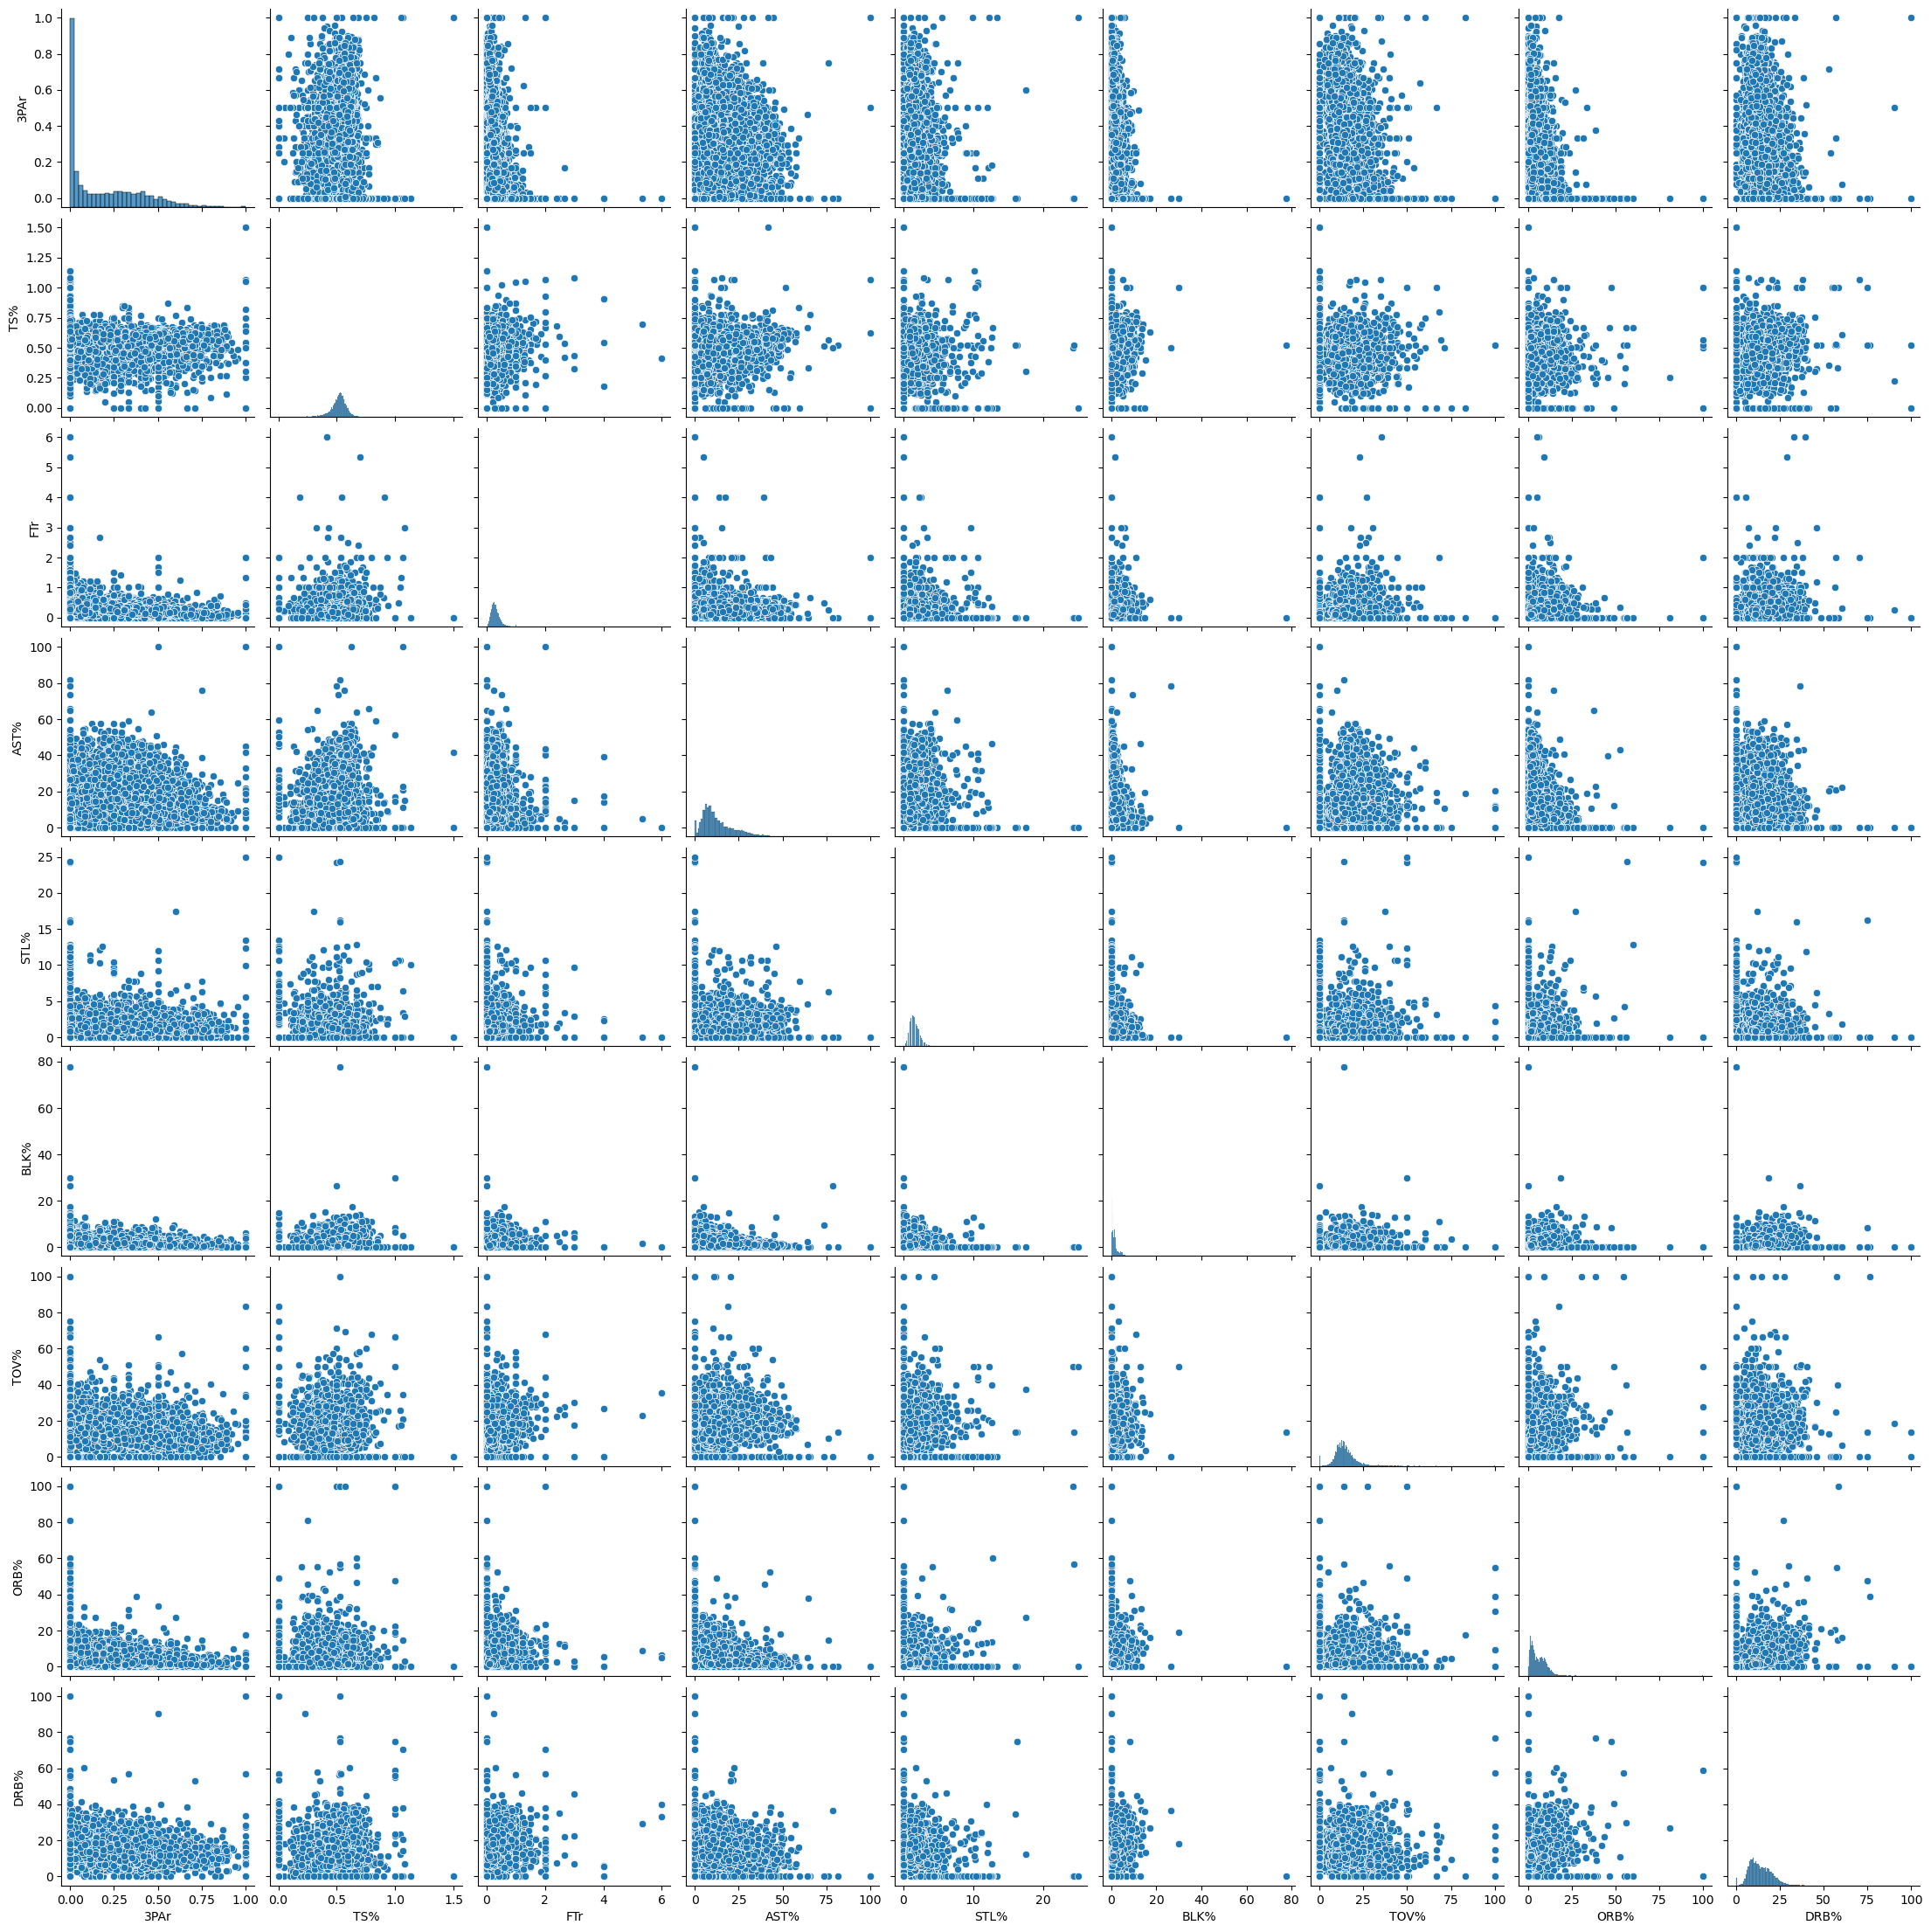

In [10]:
# seaborn pair plot
sns.pairplot(df_numeric[['3PAr','TS%','FTr','AST%','STL%','BLK%','TOV%','ORB%','DRB%']])

There are interesting trends when we evaluate columns extracted from the 3 dataframes:
- Efficiency columns - 3P%, FG%, FT% - all appear normally distributed as well, which makes sense given these columns have been normalized. 
- Remaining columns are left skewed.
- Linear Relationships exist between the several variables to name a few:
    - DRB and ORB
    - PTS and AST
    - PTS and STL
    - TOV and PTS
    - TOV and AST

### Independent Variables (Categorical) <a id="1.2"></a>

Now that we have explored the numerical independent variables, lets convert the categorical columns to numerical values. 

In [11]:
df_categ = df_model.select_dtypes(['object'])
df_categ.head()

Player             Team Pos_new  Era
0          Bob Lanier  Milwaukee Bucks     Big  80s
1     Marques Johnson  Milwaukee Bucks    Wing  80s
2       Brian Winters  Milwaukee Bucks   Guard  80s
3        Pat Cummings  Milwaukee Bucks     Big  80s
4  Richard Washington  Milwaukee Bucks     Big  80s

The above columns *nominal* rather than *ordinal* so we will use the `OneHotEncoder()` so features can be expressed across binary columns. 

In [12]:
# Convert Team column to Binary

# instantiate encoder
ohe = OneHotEncoder()

# 2D array required so store as dataframe
Team = pd.DataFrame(df_model['Team'])

# fit and transform data
encoded_Team = ohe.fit_transform(Team)

# convert from sparse to dense
dense_array_Team = encoded_Team.toarray()

# Put into a dataframe to get column names
Team_df = pd.DataFrame(dense_array_Team, columns=ohe.categories_[0], dtype=float)

# Preview
Team_df.head()

Atlanta Hawks  Boston Celtics  Brooklyn Nets  Charlotte Hornets  \
0            0.0             0.0            0.0                0.0   
1            0.0             0.0            0.0                0.0   
2            0.0             0.0            0.0                0.0   
3            0.0             0.0            0.0                0.0   
4            0.0             0.0            0.0                0.0   

   Chicago Bulls  Cleveland Cavaliers  Dallas Mavericks  Denver Nuggets  \
0            0.0                  0.0               0.0             0.0   
1            0.0                  0.0               0.0             0.0   
2            0.0                  0.0               0.0             0.0   
3            0.0                  0.0               0.0             0.0   
4            0.0                  0.0               0.0             0.0   

   Detroit Pistons  Golden State Warriors  ...  Oklahoma City Thunder  \
0              0.0                    0.0  ...                    0.0   
1              0.0                    0.0  ...                    0.0   
2              0.0                    0.0  ...                    0.0   
3              0.0                    0.0  ...                    0.0   
4              0.0                    0.0  ...                    0.0   

   Orlando Magic  Philadelphia 76ers  Phoenix Suns  Portland Trail Blazers  \
0            0.0                 0.0           0.0                     0.0   
1            0.0                 0.0           0.0                     0.0   
2            0.0                 0.0           0.0                     0.0   
3            0.0                 0.0           0.0                     0.0   
4            0.0                 0.0           0.0                     0.0   

   Sacramento Kings  San Antonio Spurs  Toronto Raptors  Utah Jazz  \
0               0.0                0.0              0.0        0.0   
1               0.0                0.0              0.0        0.0   
2               0.0                0.0              0.0        0.0   
3               0.0                0.0              0.0        0.0   
4               0.0                0.0              0.0        0.0   

   Washington Wizards  
0                 0.0  
1                 0.0  
2                 0.0  
3                 0.0  
4                 0.0  

[5 rows x 30 columns]

In [13]:
# Convert Pos_new column to binary

ohe = OneHotEncoder()
Pos_new = pd.DataFrame(df_model['Pos_new'])
encoded_Pos_new = ohe.fit_transform(Pos_new)
dense_array_Pos_new = encoded_Pos_new.toarray()
Pos_df = pd.DataFrame(dense_array_Pos_new, columns=ohe.categories_[0], dtype=int)
Pos_df.head()

Big  Guard  Wing
0    1      0     0
1    0      0     1
2    0      1     0
3    1      0     0
4    1      0     0

In [14]:
# Convert Era column to binary

ohe = OneHotEncoder()
Era = pd.DataFrame(df_model['Era'])
encoded_Era = ohe.fit_transform(Era)
dense_array_Era = encoded_Era.toarray()
Era_df = pd.DataFrame(dense_array_Era, columns=ohe.categories_[0], dtype=float)
Era_df.head()

2000s  2010s  2020s  80s  90s
0    0.0    0.0    0.0  1.0  0.0
1    0.0    0.0    0.0  1.0  0.0
2    0.0    0.0    0.0  1.0  0.0
3    0.0    0.0    0.0  1.0  0.0
4    0.0    0.0    0.0  1.0  0.0

In [15]:
# Merge categorical one hot encoded arrays to 1 dataframe
df_categ = pd.concat([Era_df, Pos_df, Team_df], axis=1)

### Dependent Variable<a id="1.3"></a>

We have the luxury of performing either a classification model or a regression model to predict the 2022 NBA MVP winner given we have the MVP votes `Share` column and MVP `Rank`column that both could be target variables. We will be exploring both regression and classification models for this project. 

In [16]:
# Let us first analyze the distribution of MVP winners in the dataset.
df_model['Rank'] = np.where(df_model['Rank'] == 1, 1, 0)

df_model['Rank'].value_counts()

0    18200
1       43
Name: Rank, dtype: int64

We certainly have an imbalanced dataset! Therefore, we would need to consider `Precision` and `Recall` scores  instead of the accuracy metric to evaluate performance for the classification models. 

In [17]:
# Join categorical and numerical dataframes to form final model.
df_model_new = pd.concat([df_model[['Player','Year','Rank','Share']],df_numeric, Team_df, Pos_df, Era_df], axis=1)

# Inspect df_model_new
df_model_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18243 entries, 0 to 18242
Data columns (total 67 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Player                  18243 non-null  object 
 1   Year                    18243 non-null  int64  
 2   Rank                    18243 non-null  int64  
 3   Share                   18243 non-null  float64
 4   Age                     18243 non-null  float64
 5   MP                      18243 non-null  float64
 6   PER                     18243 non-null  float64
 7   TS%                     18243 non-null  float64
 8   3PAr                    18243 non-null  float64
 9   FTr                     18243 non-null  float64
 10  ORB%                    18243 non-null  float64
 11  DRB%                    18243 non-null  float64
 12  AST%                    18243 non-null  float64
 13  STL%                    18243 non-null  float64
 14  BLK%                    18243 non-null

## Modeling <a id="2"></a>

Now that we have a final dataframe that can be used for modeling, we can now split our dataframe into training and test sets. 

In [18]:
# Split Train and Test Sets
df_train = df_model_new[df_model_new['Year'] < 2010]
df_test = df_model_new[df_model_new['Year'] > 2010]

# Evaluate proportion of Train and Test Sets
print(f"Proportion of Training data on whole dataset: {df_train.shape[0]/(df_train.shape[0]+df_test.shape[0])*100}")
print(f"Proportion of Test data on whole dataset: {df_test.shape[0]/(df_train.shape[0]+df_test.shape[0])*100}")

Proportion of Training data on whole dataset: 65.87270378068648
Proportion of Test data on whole dataset: 34.12729621931352


In [19]:
# Split data into X and y variables
X_train = df_train.drop(columns=['Rank','Share','Player','Year'])
y_train_num = np.log1p(df_train['Share'])
y_train_class = df_train['Rank']
                         
X_test = df_test.drop(columns=['Rank','Share','Player','Year'])
y_test_num = np.log1p(df_test['Share'])
y_test_class = df_test['Rank'] 

We will first proceed with a Linear Regression model for the analysis, then perform a classification model for comparison.

### XGBoost / Random Forest Pipeline Regressors <a id="2.1"></a>

I will be using the following ensemble ML algorithms for my model: XGBoost Regressor and Random Forest Regressors. The goal of using Ensemble methods for this analysis is to use a collection of machine learning algorithms to increase predictive power and enhance model performance.

We will be passing in the following hyperparameters in a pipeline and tuning them to enhance model performance:
- **Max Depth Range** (to control overfitting): (2,10)
- **N_Estimators** (# of runs XGBoost will try to learn): (10, 50, 100)
- **Learning Rate** (learning speed): (0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7)

In [20]:
# Build ML Pipeline to pass in Regressors

#we give our estimators as a list of tuples: name:function.
estimators = [('normalise', StandardScaler()),
              ('model', XGBRegressor())]

# Develop Pipeline
pipe = Pipeline(estimators)
               
# Building model options
param_grid = [
            {'normalise': [StandardScaler()],
             'model': [XGBRegressor()],
             'model__max_depth': np.arange(2,10),
             'model__learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7],
             'model__n_estimators': [10,50,100], 'model__random_state' : [random_state_val]
            },
            {'normalise': [StandardScaler()],
             'model': [RandomForestRegressor()],
             'model__max_depth': np.arange(2,10),
             'model__n_estimators': [10,50,100], 'model__random_state' : [random_state_val]
            },
]

In [21]:
#GridSearch 
grid_reg = GridSearchCV(pipe, param_grid, verbose=5, n_jobs=-1, cv=3)

In [22]:
#Fit the model 
fittedgrid_reg = grid_reg.fit(X_train, y_train_num)

Fitting 3 folds for each of 192 candidates, totalling 576 fits
[CV 1/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__learning_rate=0.0001, model__max_depth=2, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=-105.535 total time=   1.9s
[CV 2/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel

[CV 2/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__learning_rate=0.0001, model__max_depth=2, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=-116.314 total time=   0.6s
[CV 1/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=Non

[CV 3/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__learning_rate=0.0001, model__max_depth=2, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=-128.477 total time=   0.6s
[CV 2/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=Non

[CV 1/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__learning_rate=0.0001, model__max_depth=2, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=-106.389 total time=   0.6s
[CV 3/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=Non

[CV 3/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__learning_rate=0.001, model__max_depth=4, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=-126.184 total time=   0.8s
[CV 1/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None

[CV 2/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__learning_rate=0.0001, model__max_depth=9, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=-116.314 total time=   0.9s
[CV 3/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=Non

[CV 1/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__learning_rate=0.0001, model__max_depth=8, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=-105.535 total time=   3.8s
[CV 2/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=Non

[CV 2/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__learning_rate=0.001, model__max_depth=3, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=-95.311 total time=   4.5s
[CV 3/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None

[CV 1/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__learning_rate=0.01, model__max_depth=4, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=-87.047 total time=   0.8s
[CV 2/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,


[CV 3/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__learning_rate=0.01, model__max_depth=2, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=-105.255 total time=   0.4s
[CV 1/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,

[CV 3/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__learning_rate=0.001, model__max_depth=7, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=-105.412 total time=   8.2s
[CV 1/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=Non

[CV 3/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__learning_rate=0.01, model__max_depth=7, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=-105.312 total time=   1.0s
[CV 1/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,

[CV 2/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__learning_rate=0.001, model__max_depth=9, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=-95.306 total time=   9.5s
[CV 3/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None

[CV 1/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__learning_rate=0.1, model__max_depth=2, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=-12.335 total time=   0.3s
[CV 2/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
 

[CV 2/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__learning_rate=0.1, model__max_depth=6, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.632 total time=   9.8s
[CV 3/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
  

[CV 1/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__learning_rate=0.1, model__max_depth=5, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=-12.333 total time=   0.9s
[CV 2/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
 

[CV 3/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__learning_rate=0.1, model__max_depth=4, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.438 total time=   6.4s
[CV 1/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
  

[CV 2/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__learning_rate=0.3, model__max_depth=4, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.567 total time=   0.8s
[CV 3/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
   

[CV 1/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__learning_rate=0.1, model__max_depth=8, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.558 total time=  11.5s
[CV 2/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
  

[CV 2/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__learning_rate=0.3, model__max_depth=3, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.559 total time=   0.6s
[CV 1/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
   

[CV 3/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__learning_rate=0.3, model__max_depth=7, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.327 total time=   6.7s
[CV 1/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
  

[CV 3/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__learning_rate=0.5, model__max_depth=2, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.441 total time=   1.0s
[CV 1/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
   

[CV 1/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__learning_rate=0.3, model__max_depth=9, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.534 total time=   5.6s
[CV 2/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
   

[CV 1/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__learning_rate=0.5, model__max_depth=5, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.511 total time=   0.9s
[CV 2/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
   

In [23]:
print(f" Regression model Test Score: {fittedgrid_reg.score(X_test,y_test_num)}")
print(f" Regression model Train Score: {fittedgrid_reg.score(X_train,y_train_num)}")                                       

 Regression model Test Score: 0.671924473298036
 Regression model Train Score: 0.9431301071644058


In [24]:
# Best estimator in pipeline
fittedgrid_reg.best_estimator_

Pipeline(steps=[('normalise', StandardScaler()),
                ('model',
                 RandomForestRegressor(max_depth=9, n_estimators=50,
                                       random_state=123))])

Our best model is a **Random Forest Regressor** with a **max_depth** 9 and **n_estimators** 50. The model performed poorly with significant overfitting given the huge difference between test and training scores. Let us now evaluate model predictions

In [25]:
# Get prediction values
predictions_reg = fittedgrid_reg.predict(X_test)

# Build a df
predictions_reg = pd.DataFrame(predictions_reg, columns=["Predicted MVP Votes"], index=df_test.index)

# Add player and year columns
reg_results_df = pd.concat([df_test[['Year','Player']], predictions_reg], axis=1)

# Create a filter to extract the maximum share of MVP votes in each calendar year
filter1 = reg_results_df['Predicted MVP Votes'].isin(reg_results_df.groupby('Year').max()['Predicted MVP Votes'])

# Apply filter
reg_results_df = reg_results_df[filter1]
reg_results_df

Year                 Player  Predicted MVP Votes
12502  2011           LeBron James             0.396176
12863  2012           LeBron James             0.399963
13552  2013           LeBron James             0.601065
13640  2014           Kevin Durant             0.489394
14474  2015          Stephen Curry             0.534790
14958  2016          Stephen Curry             0.559282
15072  2017           James Harden             0.377935
15707  2018           James Harden             0.435852
16225  2019  Giannis Antetokounmpo             0.371776
16673  2020           James Harden             0.299349
17327  2021           Nikola Jokić             0.378259
17740  2022  Giannis Antetokounmpo             0.330834

If we extract players with the highest MVP votes per calendar year, we have a 67% accuracy on predicting the correct MVP Winner - which is great! However, given our model significantly overfitted, we will need to explore other models to find the best model with optimum performance. 

### XGBoost / Random Forest Pipeline Classifiers <a id="2.2"></a>

#### Classification Model (Original Dataset) <a id="2.2.1"></a>

For classification, we will also be using the ensemble methods - XGB Classifier & RandomForest Classifer - for modeling.

Similar to the Regression pipeline, we will be passing in the following hyperparameters in the classification pipeline:
- **Max Depth Range** (to control overfitting): (2,10)
- **N_Estimators** (# of runs XGBoost will try to learn): (10, 50, 100)
- **Learning Rate** (learning speed): (0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7)

In [26]:
# Build ML Pipeline to pass in Classifiers

#we give our estimators as a list of tuples: name:function.
estimators = [('normalise', StandardScaler()),
              ('model', XGBClassifier())]

# Develop Pipeline
pipe = Pipeline(estimators)
               
# Building model options
param_grid = [
            {'normalise': [StandardScaler()],
             'model': [XGBClassifier()],
             'model__max_depth': np.arange(2,10), 
             'model__learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7],
             'model__n_estimators': [10,50,100], 'model__random_state' : [random_state_val]
            },
            {'normalise': [StandardScaler()],
             'model': [RandomForestClassifier()],
             'model__max_depth': np.arange(2,10), 
             'model__n_estimators': [10,50,100], 'model__random_state' : [random_state_val]
            },
]

In [27]:
#GridSearch 
grid_class = GridSearchCV(pipe, param_grid, verbose=5, n_jobs=-1, cv=3)

In [28]:
#Fit the model 
fittedgrid_class = grid_class.fit(X_train, y_train_class)

Fitting 3 folds for each of 192 candidates, totalling 576 fits
[CV 1/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__learning_rate=0.5, model__max_depth=9, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.569 total time=   1.4s
[CV 3/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,

[CV 2/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__learning_rate=0.7, model__max_depth=2, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.588 total time=   1.5s
[CV 1/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
   

[CV 2/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__learning_rate=0.5, model__max_depth=8, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.588 total time=   3.9s
[CV 3/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
   

[CV 3/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__learning_rate=0.7, model__max_depth=3, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.179 total time=   4.9s
[CV 1/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
  

[CV 3/3] END model=RandomForestRegressor(), model__max_depth=3, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.473 total time=   2.4s
[CV 1/3] END model=RandomForestRegressor(), model__max_depth=4, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.611 total time=   0.7s
[CV 2/3] END model=RandomForestRegressor(), model__max_depth=4, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.644 total time=   0.6s
[CV 3/3] END model=RandomForestRegressor(), model__max_depth=4, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.437 total time=   0.6s
[CV 1/3] END model=RandomForestRegressor(), model__max_depth=4, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.643 total time=   2.9s
[CV 2/3] END model=RandomForestRegressor(), model__max_depth=4, model__n_estimators=100, model__random_state=123, normalise=StandardSca

[14:20:58] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
         

[CV 2/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__learning_rate=0.7, model__max_depth=8, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.562 total time=   1.5s
[CV 1/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
   

[CV 3/3] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), model__learning_rate=0.7, model__max_depth=9, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.014 total time=   4.0s
[CV 3/3] END model=RandomForestRegressor(), model__max_depth=2, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score

[CV 3/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=0.0001, model__max_depth=7, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.997 total time=   2.6s
[14:21:26] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/l

[CV 1/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=0.0001, model__max_depth=5, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.997 total time=   4.7s
[14:21:15] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/

[CV 3/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=0.0001, model__max_depth=6, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.997 total time=   2.7s
[14:21:19] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/l

[CV 1/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=0.001, model__max_depth=3, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.997 total time=   0.6s
[14:21:44] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/le

/Users/husseinwarfa/opt/anaconda3/envs/Warfa2/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/husseinwarfa/opt/anaconda3/envs/Warfa2/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/husseinwarfa/opt/anaconda3/envs/Warfa2/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove thi

[CV 1/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=0.0001, model__max_depth=6, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.997 total time=   4.5s
[14:21:22] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/

[CV 3/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=0.001, model__max_depth=4, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.997 total time=   0.6s
[14:21:51] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/le

[CV 1/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=0.001, model__max_depth=2, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.997 total time=   3.4s
[14:21:46] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/l

[CV 1/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=0.001, model__max_depth=7, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.997 total time=   0.6s
[14:22:10] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/le

[CV 1/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=0.001, model__max_depth=6, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.997 total time=   4.8s
[14:22:12] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/l

/Users/husseinwarfa/opt/anaconda3/envs/Warfa2/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/husseinwarfa/opt/anaconda3/envs/Warfa2/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/husseinwarfa/opt/anaconda3/envs/Warfa2/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove thi

[CV 1/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=0.001, model__max_depth=9, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.997 total time=   5.0s
[14:22:33] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/l

/Users/husseinwarfa/opt/anaconda3/envs/Warfa2/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/husseinwarfa/opt/anaconda3/envs/Warfa2/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/husseinwarfa/opt/anaconda3/envs/Warfa2/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove thi

/Users/husseinwarfa/opt/anaconda3/envs/Warfa2/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/husseinwarfa/opt/anaconda3/envs/Warfa2/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/husseinwarfa/opt/anaconda3/envs/Warfa2/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove thi

[CV 1/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=0.001, model__max_depth=8, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.997 total time=   5.2s
[14:22:26] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/l

[CV 2/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=0.01, model__max_depth=3, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.998 total time=   2.4s
[14:22:40] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/lea

[CV 3/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=0.01, model__max_depth=3, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.996 total time=   0.6s
[14:22:37] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/lea

[CV 3/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=0.01, model__max_depth=6, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.996 total time=   0.7s
[14:22:57] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/lea

[CV 1/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=0.01, model__max_depth=9, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.997 total time=   0.6s
[14:23:17] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/lea

/Users/husseinwarfa/opt/anaconda3/envs/Warfa2/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/husseinwarfa/opt/anaconda3/envs/Warfa2/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/husseinwarfa/opt/anacon

[CV 2/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=0.1, model__max_depth=2, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.998 total time=   0.4s
[14:23:25] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/lear

[CV 1/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=0.01, model__max_depth=7, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.997 total time=   2.9s
[14:23:07] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/lea

[CV 1/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.998 total time=   4.4s
[14:23:38] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/lea

/Users/husseinwarfa/opt/anaconda3/envs/Warfa2/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/husseinwarfa/opt/anaconda3/envs/Warfa2/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/husseinwarfa/opt/anacon

[CV 2/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=0.1, model__max_depth=5, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.998 total time=   0.6s
[14:23:43] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/lear

/Users/husseinwarfa/opt/anaconda3/envs/Warfa2/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/husseinwarfa/opt/anaconda3/envs/Warfa2/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/husseinwarfa/opt/anacon

[CV 2/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=0.1, model__max_depth=6, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.998 total time=   0.7s
[14:23:49] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/lear

/Users/husseinwarfa/opt/anaconda3/envs/Warfa2/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/husseinwarfa/opt/anaconda3/envs/Warfa2/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/husseinwarfa/opt/anacon

[CV 1/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=0.3, model__max_depth=2, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.997 total time=   0.4s
[14:24:16] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/lear

[14:23:56] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
         

[CV 3/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=0.3, model__max_depth=5, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.998 total time=   0.9s
[14:24:34] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/lear

[CV 3/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=0.3, model__max_depth=5, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.998 total time=   2.3s
[14:24:37] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/lear

/Users/husseinwarfa/opt/anaconda3/envs/Warfa2/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/husseinwarfa/opt/anaconda3/envs/Warfa2/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/husseinwarfa/opt/anacon

[14:24:41] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
         

[CV 3/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=0.5, model__max_depth=2, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.998 total time=   0.5s
[14:25:01] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/lear

/Users/husseinwarfa/opt/anaconda3/envs/Warfa2/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/husseinwarfa/opt/anaconda3/envs/Warfa2/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/husseinwarfa/opt/anacon

[CV 3/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=0.3, model__max_depth=8, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.998 total time=   0.8s
[14:24:51] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/lear

[CV 1/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=0.5, model__max_depth=4, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.998 total time=   2.3s
[14:25:13] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/lear

/Users/husseinwarfa/opt/anaconda3/envs/Warfa2/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/husseinwarfa/opt/anaconda3/envs/Warfa2/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/husseinwarfa/opt/anacon

[CV 3/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=0.5, model__max_depth=6, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.998 total time=   2.6s
[14:25:26] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/lear

[14:25:17] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
         

[CV 3/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=0.5, model__max_depth=6, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.998 total time=   0.7s
[14:25:22] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/lear

/Users/husseinwarfa/opt/anaconda3/envs/Warfa2/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/husseinwarfa/opt/anaconda3/envs/Warfa2/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/husseinwarfa/opt/anacon

[14:26:36] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [29]:
print(f" Classification model Test Score: {fittedgrid_class.score(X_test,y_test_class)}")
print(f" Classification model Train Score: {fittedgrid_class.score(X_train,y_train_class)}")                                       

 Classification model Test Score: 0.9981893004115227
 Classification model Train Score: 0.9988060719768037


In [30]:
# Evaluate best estimator in pipeline
fittedgrid_class.best_estimator_

Pipeline(steps=[('normalise', StandardScaler()),
                ('model',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, enable_categorical=False,
                               gamma=0, gpu_id=-1, importance_type=None,
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=2,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=50,
                               n_jobs=4, num_parallel_tree=1, predictor='auto',
                               random_state=123, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=1, subsample=1,
                               tree_method='exact', validate_parameters=1,
                               verbosity=None))])

Our best classifier is the XGBClassifier with a **max_depth** of 2, **learning rate** of 0.1 and **n_estimators** of 50. We have noticed a sizeable increase on model accuracy from the previous regression model; however, due to the vast majority of the data points being in class 0 (see below), the model has a high probabiltiy of predicting class 0 vs class 1. As such, we will likely have very a low recall, but a high precision. Let us evaluate predictions using the model probabilities

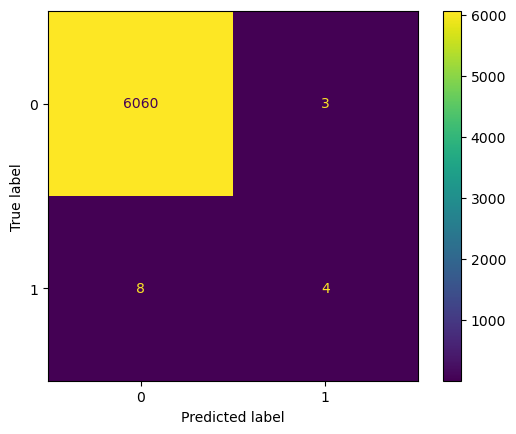

In [31]:
plot_confusion_matrix(fittedgrid_class, X_test, y_test_class);

As you can see above, we have a significant class imbalance! Therefore, using accuracy to evaluate model performance is misleading and we will need to consider other metrics to for model evaluation. First, lets explore our model predictions from the above ML pipeline created.

In [32]:
# Get prediction values
proba_class = fittedgrid_class.predict_proba(X_test)[:,1]
prediction_class = fittedgrid_class.predict(X_test)

# Display Classification Report
class_report = classification_report(y_test_class, prediction_class)
print(class_report)

# Build a df
proba_class_df = pd.DataFrame(proba_class, columns=["Probability of MVP"], index=df_test.index)

# Add player and year columns
results_df_class = pd.concat([df_test[['Year','Player']], proba_class_df], axis=1)

# Create a filter to extract the maximum share of MVP votes in each calendar year
max_proba_per_year = results_df_class.groupby('Year')["Probability of MVP"].idxmax()

# Apply filter
results_df_class = results_df_class.loc[max_proba_per_year]
results_df_class

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6063
           1       0.57      0.33      0.42        12

    accuracy                           1.00      6075
   macro avg       0.79      0.67      0.71      6075
weighted avg       1.00      1.00      1.00      6075



Year                 Player  Probability of MVP
12502  2011           LeBron James            0.305949
12863  2012           LeBron James            0.568132
13552  2013           LeBron James            0.653872
13640  2014           Kevin Durant            0.446960
14474  2015          Stephen Curry            0.863149
14958  2016          Stephen Curry            0.653872
15017  2017          Kawhi Leonard            0.305949
15707  2018           James Harden            0.288460
16225  2019  Giannis Antetokounmpo            0.288460
16590  2020           LeBron James            0.055287
17327  2021           Nikola Jokić            0.088853
17965  2022           Nikola Jokić            0.063036

The default threshold on the classification model is 0.5 and, as expected, we have a lower recall and high precision for the class 1 predictions (**precision = 0.57, recall = 0.33**). Despite this, we were able to correctly predict the the 2022 NBA MVP winner - Nikola Jokic. However, in addition to predicting the 2022 NBA MVP,  the objective is for the model to identify players that would be of deserving of the award from previous years. <br>
Looking at the above probabilities, the lowest probability in each NBA season is in 2020, where Lebron James had the highest probability (0.055287) on becoming the NBA MVP. Therefore, to ensure we classify at least 1 MVP candidate from 2010, we will set our threshold at 0.055287 to capture NBA MVP predictions for the last 12 seasons. With this low threshold, we will reduce precision and increase recall as these 2 metrics are usually a trade-off with one another. <br>

Firstly, let us proceed with plotting the precision and recall scores at various threshold amounts. 

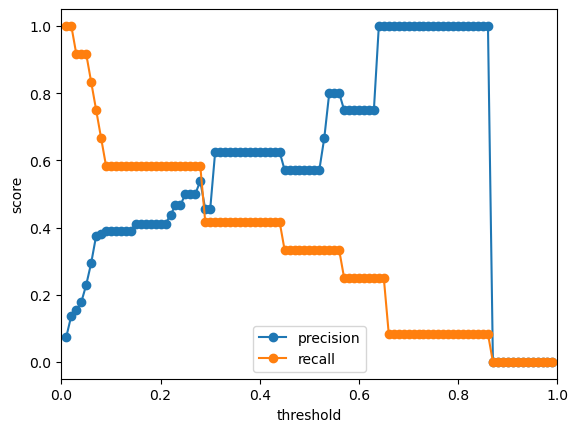

In [33]:
# Vary thresholds by 0.05 from 0.05 to 0.95
thresholds = np.arange(0.01, 1, 0.01)

precisions = list()
recalls = list()

for threshold in thresholds:

    # Apply threshold
    y_threshold = np.where(proba_class > threshold, 1, 0)
    
    # Calculate precision and recall
    precision = precision_score(y_test_class, y_threshold)
    recall = recall_score(y_test_class, y_threshold)
    
    # Append to list
    precisions.append(precision)
    recalls.append(recall)

# Visualize the result
plt.figure()
plt.plot(thresholds, precisions, label='precision', marker='o')
plt.plot(thresholds, recalls, label='recall', marker='o')
plt.xlim(0, 1)
plt.xlabel('threshold')
plt.ylabel('score')
plt.legend()
plt.show()

To optimize for recall and precision, we would need to target ~ 0.24 threshold. However, the goal here is to predict the NBA MVP Winner and also identify other suitable candidates from previous years. Therefore, we would need to lower our threshold to 0.055287 to ensure our model can predict at least 1 MVP winner from each season

In [34]:
# Create new threshold
threshold = 0.055287 - 0.000001 

# If the probability that a data point belongs to the positive class is greater than 0.01328, 
# it gets classified as 1; otherwise, it gets classified as 0
y_pred = np.where(proba_class >= threshold, 1, 0)

class_df_threshold = classification_report(y_test_class, y_pred)
print(f"Classification report for a threshold of {threshold} \n")
print(class_df_threshold)

# Build a df
prob_class_thresh = pd.DataFrame(y_pred, columns=["MVP Prediction"], index=df_test.index)

# Add player and year columns
prob_class_thresh = pd.concat([df_test[['Year','Player']], prob_class_thresh], axis=1)

# Filter out MVPs
prob_class_thresh = prob_class_thresh[prob_class_thresh["MVP Prediction"] == 1]

# Add probabilities from model
prob_class_thresh['Probability of MVP'] = proba_class_df.loc[prob_class_thresh.index]

# Sort the dataframe based on Year and Probability
prob_class_thresh.sort_values(["Year", "Probability of MVP"], axis = 0, ascending = True,
               inplace = True, na_position = "first")

# Preview df
prob_class_thresh

Classification report for a threshold of 0.055286 

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      6063
           1       0.23      0.83      0.36        12

    accuracy                           0.99      6075
   macro avg       0.62      0.91      0.68      6075
weighted avg       1.00      0.99      1.00      6075



Year                 Player  MVP Prediction  Probability of MVP
12373  2011              Pau Gasol               1            0.066606
12504  2011            Dwyane Wade               1            0.066703
12442  2011           Derrick Rose               1            0.073457
12365  2011          Dwight Howard               1            0.142902
12502  2011           LeBron James               1            0.305949
12958  2012           Kevin Durant               1            0.066703
12862  2012            Dwyane Wade               1            0.078801
12863  2012           LeBron James               1            0.568132
13171  2013             Chris Paul               1            0.214390
13192  2013           Kevin Durant               1            0.634682
13552  2013           LeBron James               1            0.653872
13671  2014             Kevin Love               1            0.063036
13751  2014             Chris Paul               1            0.066703
14014  2014           LeBron James               1            0.089251
13640  2014           Kevin Durant               1            0.446960
14313  2015           James Harden               1            0.058537
14360  2015             Chris Paul               1            0.527390
14474  2015          Stephen Curry               1            0.863149
14544  2016           LeBron James               1            0.241998
14901  2016      Russell Westbrook               1            0.273679
14889  2016           Kevin Durant               1            0.305949
14582  2016          Kawhi Leonard               1            0.530857
14958  2016          Stephen Curry               1            0.653872
15137  2017           Jimmy Butler               1            0.056649
15179  2017          Stephen Curry               1            0.066703
15183  2017           Kevin Durant               1            0.066703
15072  2017           James Harden               1            0.226969
15017  2017          Kawhi Leonard               1            0.305949
15716  2018             Chris Paul               1            0.055287
15962  2018           Kevin Durant               1            0.055287
15969  2018          Stephen Curry               1            0.055287
15524  2018           LeBron James               1            0.063036
15707  2018           James Harden               1            0.288460
16050  2019          Stephen Curry               1            0.055287
16043  2019           Kevin Durant               1            0.066703
16172  2019            Rudy Gobert               1            0.070389
16314  2019           James Harden               1            0.088853
16225  2019  Giannis Antetokounmpo               1            0.288460
16590  2020           LeBron James               1            0.055287
17412  2021  Giannis Antetokounmpo               1            0.055287
17474  2021          Kawhi Leonard               1            0.055287
17327  2021           Nikola Jokić               1            0.088853
17965  2022           Nikola Jokić               1            0.063036

With a 0.055287 threshold, our model is able to predict NBA MVPs from each calendar year and we have correctly predicted Nikola Jokic as the 2022 NBA MVP Winner! However, with the low threshold, we have introduced more false positives i.e Kawhi Leonard and Giannis Antetokounmpo in 2021, to capture MVP prediction. Given that the goal of this project is to predict the 2022 NBA MVP Winner and evaluate other candidates deserving of the award, we are tolerant of introducing false positives in our model predictions. To truly understand our model performance, lets evaluate our AUC score on this model. 

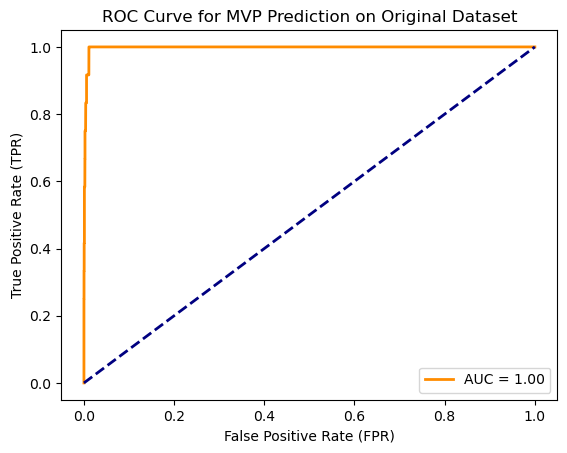

Area under curve (AUC):0.9977046566606191



In [35]:
## Plot AUC Curve ##

# Assign False positive rates, True positive rates and threholds from the ROC Curves
fprs, tprs, thresholds = roc_curve(y_test_class, proba_class)

# Determine AUC Score
roc_auc = roc_auc_score(y_test_class, proba_class)

# Plot Curve
plt.figure()
plt.plot(fprs, tprs, color='darkorange',
         lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for MVP Prediction on Original Dataset')
plt.legend(loc="best")
plt.show()

print(f'Area under curve (AUC):{roc_auc}')
print()

We have a really high AUC score! This is great! This means at very low thresholds, our classifier is significantly better at distinguishing between the true positives and true negatives. However, as we saw earlier with the low threshold, we introduced far more false positives than we would like. To potentially improve our model, we can "upsample" the minority class. This entails us resampling the observations that belong to "class 1" so that our training data has a relatively equal distribution between the 2 classes.

#### Classification Model (Upsampled Dataset) <a id="2.2.2"></a>

In [36]:
# Upsample our Training data

X_class_upsampled, y_class_upsampled = resample(X_train[y_train_class == 1], 
                                    y_train_class[y_train_class == 1], 
                                    replace=True, 
                                    n_samples=X_train[y_train_class == 0].shape[0], # the number majority-class rows
                                    random_state=random_state_val)

print('Number of class 1 examples before:', X_train[y_train_class == 1].shape[0])
print('Number of class 1 examples after:', X_class_upsampled.shape[0])
print('Number of class 0 examples:', X_train[y_train_class == 0].shape[0])

Number of class 1 examples before: 30
Number of class 1 examples after: 11696
Number of class 0 examples: 11696


In [37]:
# Combine upsample with original data
X_train_bal = np.vstack((X_train[y_train_class == 0], X_class_upsampled))
y_train_bal = np.hstack((y_train_class[y_train_class == 0], y_class_upsampled))

In [38]:
#GridSearch 
grid_up_class = GridSearchCV(pipe, param_grid, verbose=5, n_jobs=-1, cv=3)

#Fit the model 
fittedgrid_up_class = grid_up_class.fit(X_train_bal, y_train_bal)

Fitting 3 folds for each of 192 candidates, totalling 576 fits
[CV 2/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=0.7, model__max_depth=3, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.998 total time=   2.0s
[14:25:51] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44t

[CV 2/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=0.7, model__max_depth=3, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.998 total time=   3.6s
[14:25:54] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/lea

[CV 1/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=0.5, model__max_depth=9, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.998 total time=   3.7s
[14:25:43] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/lea

[14:25:49] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
         

/Users/husseinwarfa/opt/anaconda3/envs/Warfa2/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/husseinwarfa/opt/anaconda3/envs/Warfa2/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/husseinwarfa/opt/anacon

[CV 3/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=0.7, model__max_depth=7, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.998 total time=   3.4s
[14:26:14] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/lea

/Users/husseinwarfa/opt/anaconda3/envs/Warfa2/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/husseinwarfa/opt/anaconda3/envs/Warfa2/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/husseinwarfa/opt/anacon

[CV 1/3] END model=RandomForestClassifier(), model__max_depth=2, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.997 total time=   0.2s
[CV 2/3] END model=RandomForestClassifier(), model__max_depth=2, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.997 total time=   0.2s
[CV 3/3] END model=RandomForestClassifier(), model__max_depth=2, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.997 total time=   0.2s
[CV 1/3] END model=RandomForestClassifier(), model__max_depth=2, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.997 total time=   0.7s
[CV 2/3] END model=RandomForestClassifier(), model__max_depth=2, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.997 total time=   0.6s
[CV 1/3] END model=RandomForestClassifier(), model__max_depth=2, model__n_estimators=100, model__random_state=123, normalise=Stand

[CV 3/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=0.7, model__max_depth=8, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.998 total time=   3.3s
[14:26:19] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/lea

[CV 2/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), model__learning_rate=0.7, model__max_depth=9, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.997 total time=   0.8s
[14:26:17] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/lear

/Users/husseinwarfa/opt/anaconda3/envs/Warfa2/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/husseinwarfa/opt/anaconda3/envs/Warfa2/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/husseinwarfa/opt/anacon

[CV 2/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=123, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.0001, model__max_depth=6, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.995 total time=   1.5s
[14:27:24] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner

[14:27:11] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=123, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=Non

[CV 1/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=123, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.0001, model__max_depth=5, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.993 total time=  11.7s
[14:27:27] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learne

/Users/husseinwarfa/opt/anaconda3/envs/Warfa2/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/husseinwarfa/opt/anaconda3/envs/Warfa2/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/husseinwarfa/opt/anacon

[CV 3/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=123, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.001, model__max_depth=2, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.989 total time=   0.7s
[14:28:38] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.

/Users/husseinwarfa/opt/anaconda3/envs/Warfa2/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/husseinwarfa/opt/anaconda3/envs/Warfa2/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/husseinwarfa/opt/anacon

[14:27:12] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=123, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=Non

[CV 1/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=123, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.001, model__max_depth=6, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.993 total time=   1.5s
[14:29:27] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.

[14:28:29] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=123, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=Non

[CV 3/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=123, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.001, model__max_depth=5, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.993 total time=   1.4s
[14:29:18] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.

/Users/husseinwarfa/opt/anaconda3/envs/Warfa2/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/husseinwarfa/opt/anaconda3/envs/Warfa2/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/husseinwarfa/opt/anacon

[CV 2/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=123, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.01, model__max_depth=2, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.988 total time=   1.3s
[14:30:47] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.c

[14:31:05] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=123, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=Non

[14:29:19] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=123, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=Non

/Users/husseinwarfa/opt/anaconda3/envs/Warfa2/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/husseinwarfa/opt/anaconda3/envs/Warfa2/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/husseinwarfa/opt/anacon

[14:32:02] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=123, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=Non

/Users/husseinwarfa/opt/anaconda3/envs/Warfa2/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/husseinwarfa/opt/anaconda3/envs/Warfa2/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/husseinwarfa/opt/anacon

/Users/husseinwarfa/opt/anaconda3/envs/Warfa2/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/husseinwarfa/opt/anaconda3/envs/Warfa2/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/husseinwarfa/opt/anacon

[CV 1/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=123, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.01, model__max_depth=5, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.993 total time=   6.1s
[14:31:34] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.c

[14:31:35] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=123, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=Non

[CV 1/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=123, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.001, model__max_depth=9, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.995 total time=   9.3s
[14:30:36] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.

[14:33:03] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=123, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=Non

[14:33:47] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=123, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=Non

/Users/husseinwarfa/opt/anaconda3/envs/Warfa2/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/husseinwarfa/opt/anaconda3/envs/Warfa2/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/husseinwarfa/opt/anacon

[CV 2/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=123, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.01, model__max_depth=9, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.996 total time=  18.7s
[14:33:05] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.

[14:33:32] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=123, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=Non

[CV 2/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=123, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.1, model__max_depth=2, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.997 total time=   6.3s
[14:33:11] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.c

[14:35:00] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=123, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=Non

[CV 2/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=123, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.3, model__max_depth=3, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.996 total time=   1.0s
[14:35:12] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc

/Users/husseinwarfa/opt/anaconda3/envs/Warfa2/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/husseinwarfa/opt/anaconda3/envs/Warfa2/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/husseinwarfa/opt/anacon

/Users/husseinwarfa/opt/anaconda3/envs/Warfa2/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/husseinwarfa/opt/anaconda3/envs/Warfa2/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/husseinwarfa/opt/anacon

[14:34:42] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=123, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=Non

/Users/husseinwarfa/opt/anaconda3/envs/Warfa2/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/husseinwarfa/opt/anaconda3/envs/Warfa2/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/husseinwarfa/opt/anacon

[CV 3/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=123, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.3, model__max_depth=3, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.995 total time=   1.2s
[14:35:13] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc

[CV 2/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=123, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.3, model__max_depth=7, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.999 total time=   8.1s
[14:36:09] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.c

[14:35:45] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=123, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=Non

[14:36:07] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=123, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=Non

/Users/husseinwarfa/opt/anaconda3/envs/Warfa2/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/husseinwarfa/opt/anaconda3/envs/Warfa2/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/husseinwarfa/opt/anacon

[CV 1/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=123, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.5, model__max_depth=5, model__n_estimators=10, model__random_state=123, normalise=StandardScaler();, score=0.997 total time=   1.2s
[14:36:54] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc

[CV 2/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=123, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.5, model__max_depth=2, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.999 total time=   5.3s
[14:36:39] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.c

[14:37:18] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=123, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=Non

[14:36:46] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=123, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=Non

/Users/husseinwarfa/opt/anaconda3/envs/Warfa2/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/husseinwarfa/opt/anaconda3/envs/Warfa2/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/husseinwarfa/opt/anacon

/Users/husseinwarfa/opt/anaconda3/envs/Warfa2/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/husseinwarfa/opt/anaconda3/envs/Warfa2/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/husseinwarfa/opt/anacon

[CV 3/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=123, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.5, model__max_depth=8, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.998 total time=   6.6s
[14:37:36] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.c

[14:37:48] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=123, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=Non

[CV 2/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=123, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.5, model__max_depth=8, model__n_estimators=100, model__random_state=123, normalise=StandardScaler();, score=0.999 total time=   6.7s
[14:37:34] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.c

[14:39:07] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [39]:
print(f" XGB model Test Score: {fittedgrid_up_class.score(X_test,y_test_class)}")
print(f" XGB model Train Score: {fittedgrid_up_class.score(X_train_bal,y_train_bal)}")                                       

 XGB model Test Score: 0.9978600823045267
 XGB model Train Score: 1.0


In [40]:
fittedgrid_up_class.best_estimator_

Pipeline(steps=[('normalise', StandardScaler()),
                ('model',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, enable_categorical=False,
                               gamma=0, gpu_id=-1, importance_type=None,
                               interaction_constraints='', learning_rate=0.7,
                               max_delta_step=0, max_depth=7,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=50,
                               n_jobs=4, num_parallel_tree=1, predictor='auto',
                               random_state=123, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=1, subsample=1,
                               tree_method='exact', validate_parameters=1,
                               verbosity=None))])

Our best classifier is the XGBClassifier with a **max_depth** of 7, **learning rate** of 0.7 and **n_estimators** of 50. In terms of training and test scores, we have similar model results in comparison with the imbalanced dataset. Lets display the confusion matrix to evaluate false positives and false negatives on the imbalanced and upsampled datasets. 

Text(0.5, 1.0, 'Upsampled Confusion Matrix')

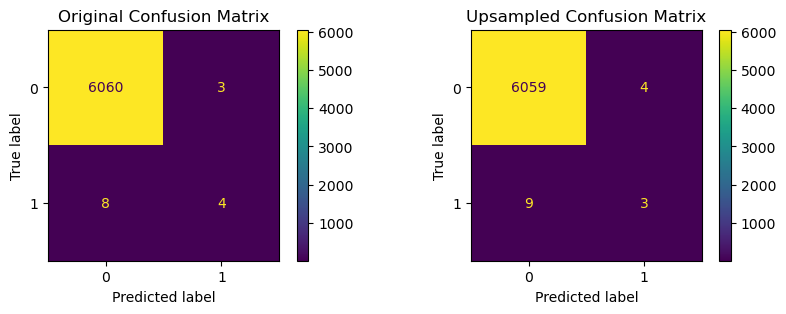

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

plot_confusion_matrix(fittedgrid_class, X_test, y_test_class, ax=axes[0])
axes[0].set_title('Original Confusion Matrix')

plot_confusion_matrix(fittedgrid_up_class, X_test, y_test_class, ax = axes[1])
axes[1].set_title('Upsampled Confusion Matrix')

The upsampled dataset hasnt really addressed the class imbalanced when analyzing the confusion matrix. We still have quite an imbalanced dataset with a significant share of the votes in the 0 class. Regardless, lets proceed to analyze model predictions with the new dataset.

In [42]:
# Get prediction values
proba_up_class = fittedgrid_up_class.predict_proba(X_test)[:,1]
prediction_up_class = fittedgrid_up_class.predict(X_test)

# Display Classification Report
up_class_report = classification_report(y_test_class, prediction_up_class)
print(up_class_report)

# Build a df
proba_up_class_df = pd.DataFrame(proba_up_class, columns=["Probability of MVP"], index=df_test.index)

# Add player and year columns
results_df_up_class = pd.concat([df_test[['Year','Player']], proba_up_class_df], axis=1)

# Create a filter to extract the maximum share of MVP votes in each calendar year
max_up_proba_per_year = results_df_up_class.groupby('Year')["Probability of MVP"].idxmax()

# Apply filter
results_df_up_class = results_df_up_class.loc[max_up_proba_per_year]
results_df_up_class

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6063
           1       0.43      0.25      0.32        12

    accuracy                           1.00      6075
   macro avg       0.71      0.62      0.66      6075
weighted avg       1.00      1.00      1.00      6075



Year                 Player  Probability of MVP
12502  2011           LeBron James            0.999291
12863  2012           LeBron James            0.033179
13552  2013           LeBron James            0.998391
13640  2014           Kevin Durant            0.969600
14360  2015             Chris Paul            0.944528
14901  2016      Russell Westbrook            0.064082
15183  2017           Kevin Durant            0.025868
15707  2018           James Harden            0.001813
16225  2019  Giannis Antetokounmpo            0.606698
17091  2020  Giannis Antetokounmpo            0.011228
17117  2021         Damian Lillard            0.000404
18007  2022             Chris Paul            0.024627

With a 0.5 threshold on the upsampled dataset, our model predictions have a lower recall, precision and F1-score for the positive class vs imbalanced dataset - therefore, no improvement with respect to scoring metrics on the the upsampled dataset. 

To predict MVP winners and suitable candidates from each season, we will again explore lowering the threhold to cast a wider net and capture more predictions; as such, we will set our threshold at 0.000404 - the lowest probability of a winning MVP from among the past 12 seasons (Damian Lillard in 2021)

In [43]:
# Set Threshold
threshold = 0.000404 - 0.000001

# If the probability that a data point belongs to the positive class is greater than 0.007531, 
# it gets classified as 1; otherwise, it gets classified as 0
y_pred_up = np.where(proba_up_class > threshold, 1, 0)

up_threshold_class_report = classification_report(y_test_class, y_pred_up)
print(f"Classification report for a threshold of {threshold} \n")
print(up_threshold_class_report)

# Build a df
prob_up_class = pd.DataFrame(y_pred_up, columns=["MVP Prediction"], index=df_test.index)

# Add player and year columns
results_up_class = pd.concat([df_test[['Year','Player']], prob_up_class], axis=1)

# Filter out MVPs
results_up_class = results_up_class[results_up_class["MVP Prediction"] == 1]

# Add probabilities from model
results_up_class['Probability of MVP'] = proba_up_class_df.loc[results_up_class.index]

# Sort the dataframe based on Year and Probability
results_up_class.sort_values(["Year", "Probability of MVP"], axis = 0, ascending = True,
               inplace = True, na_position = "first")

# Preview df
results_up_class

Classification report for a threshold of 0.000403 

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      6063
           1       0.21      0.83      0.34        12

    accuracy                           0.99      6075
   macro avg       0.61      0.91      0.67      6075
weighted avg       1.00      0.99      1.00      6075



Year                 Player  MVP Prediction  Probability of MVP
12365  2011          Dwight Howard               1            0.002597
12346  2011             Chris Paul               1            0.008898
12373  2011              Pau Gasol               1            0.010394
12442  2011           Derrick Rose               1            0.278381
12504  2011            Dwyane Wade               1            0.995540
12502  2011           LeBron James               1            0.999291
12645  2012            Rajon Rondo               1            0.001076
12720  2012             Steve Nash               1            0.002173
12863  2012           LeBron James               1            0.033179
13280  2013            Tony Parker               1            0.001266
13171  2013             Chris Paul               1            0.010777
13194  2013      Russell Westbrook               1            0.172980
13192  2013           Kevin Durant               1            0.974496
13552  2013           LeBron James               1            0.998391
13879  2014            Joakim Noah               1            0.000451
13751  2014             Chris Paul               1            0.042257
14014  2014           LeBron James               1            0.052803
13758  2014          Blake Griffin               1            0.229067
13640  2014           Kevin Durant               1            0.969600
14474  2015          Stephen Curry               1            0.003587
14431  2015           LeBron James               1            0.007266
14360  2015             Chris Paul               1            0.944528
14889  2016           Kevin Durant               1            0.002489
14958  2016          Stephen Curry               1            0.005734
14954  2016         Draymond Green               1            0.006386
14544  2016           LeBron James               1            0.006798
14582  2016          Kawhi Leonard               1            0.010522
14901  2016      Russell Westbrook               1            0.064082
15034  2017       Boban Marjanović               1            0.000457
15457  2017             Kyle Lowry               1            0.000616
15240  2017            Rudy Gobert               1            0.001385
15107  2017      Russell Westbrook               1            0.001969
15189  2017         Draymond Green               1            0.003529
15017  2017          Kawhi Leonard               1            0.004452
15072  2017           James Harden               1            0.004969
15183  2017           Kevin Durant               1            0.025868
15734  2018           Kyrie Irving               1            0.000445
16038  2018          Anthony Davis               1            0.000589
15716  2018             Chris Paul               1            0.000686
15707  2018           James Harden               1            0.001813
16564  2019          Anthony Davis               1            0.000626
16217  2019           Trevon Duval               1            0.000934
16225  2019  Giannis Antetokounmpo               1            0.606698
16590  2020           LeBron James               1            0.000995
17091  2020  Giannis Antetokounmpo               1            0.011228
17117  2021         Damian Lillard               1            0.000404
18007  2022             Chris Paul               1            0.024627

Again, with the 0.000404 threshold, we were able to substantially increase recall from **0.25** to **0.83** on the upsampled dataset - rhis is the same recall score as the XGB Regressor model on the original dataset run with a 0.055287 threshold! On this model as well, we have introduced a significant number of false positives, which is acceptable as we can now view potential MVP candidates from each season.  

Let us evaluate another metric - AUC - for further model evaluation.

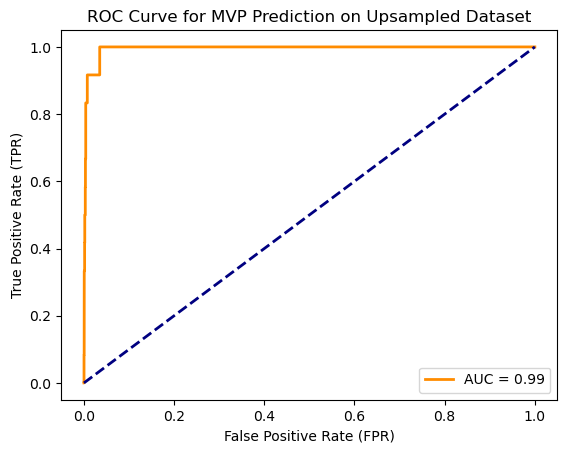

Area under curve (AUC):0.9948457859145637



In [44]:
## Plot AUC Curve ##

# Assign False positive rates, True positive rates and threholds from the ROC Curves
up_fprs, up_tprs, up_thresholds = roc_curve(y_test_class, proba_up_class)

# Determine AUC Score
up_roc_auc = roc_auc_score(y_test_class, proba_up_class)

plt.figure()
plt.plot(up_fprs, up_tprs, color='darkorange',
         lw=2, label='AUC = %0.2f' % up_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for MVP Prediction on Upsampled Dataset')
plt.legend(loc="best")
plt.show()

print(f'Area under curve (AUC):{up_roc_auc}')
print()

AUC score on the XGB Regressor on the upsampled dataset is slightly lower than on the XGB classifier on the original dataset model. At lower threshold, the Upsampled Model will classify positive classes over negative classes at a lower percentage relative to the Original Dataset Model. 

We will compare the upsampled and imabalanced further on this notebook; in the meantime, let's explore further regression and classification models using deep neural networks and see if we can generate better model performance. 

### Keras Regressor <a id="2.3"></a>

Similar to the bagging / boosting models, we will proceed with a neural network regressor and evaluate our model performance & predictions.

We will first create a function that develops a model (required for KerasRegressor) and a Machine learning pipeline to tune the following hyperparamters:
- **Units**: (10, 50, 100)
- **Learning Rate**: (0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7)
- **Dropout**: (0.1, 0.2, 0.5, 0.8)

In [45]:
# Create function
def create_model(unit, learning_rate, drop_out):
    model = keras.Sequential()
    model.add(layers.Dense(unit, activation="relu"))
    model.add(layers.Dropout(drop_out))
    model.add(layers.BatchNormalization()) 
    
    model.add(layers.Dense(unit, activation="relu"))
    model.add(layers.Dropout(drop_out))
    model.add(layers.BatchNormalization()) 
    
    model.add(layers.Dense(unit, activation="relu"))
    model.add(layers.Dropout(drop_out))
    model.add(layers.BatchNormalization()) 

    # Declare the output layer
    model.add(layers.Dense(1))
    
    # compile model
    model.compile(loss = 'MeanSquaredError',
                  optimizer = keras.optimizers.Adam(learning_rate = learning_rate),
                  metrics = ['accuracy'])

    return model

In [46]:
# Create regressor model
keras_regressor = KerasRegressor(build_fn=create_model, verbose=1)

# Specify estimators
estimators = [('normalise', StandardScaler()),
              ('model', keras_regressor)]

# Develop hyperparameter grid
param_grid = {'normalise': [StandardScaler()],
              'model__unit': [100],
              'model__epochs': [100],
              'model__learning_rate': [0.0001,0.01, 0.1, 0.5, 0.7],
              'model__drop_out': [0.1],                                     
             }

# Develop Pipeline
pipe = Pipeline(estimators)

# Develop GridSearch
DNN_grid = GridSearchCV(estimator=pipe, param_grid=param_grid, cv = 3,
                    return_train_score = True, n_jobs=-1, verbose=1)

# Fit the model
DNN_grid_result = DNN_grid.fit(X_train, y_train_num)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 3/3] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=123, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__learning_rate=0.7, model__max_depth=7, model__n_estimators=50, model__random_state=123, normalise=StandardScaler();, score=0.998 total time=   3.8s
[14:38:27] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/c

245/245 [==============================] - 5s 8ms/step - loss: 0.1101 - accuracy: 0.9325
Epoch 2/100
245/245 [==============================] - 5s 8ms/step - loss: 1.0457 - accuracy: 0.6674
Epoch 2/100
245/245 [==============================] - 5s 8ms/step - loss: 1.1204 - accuracy: 0.6645
Epoch 2/100
245/245 [==============================] - 2s 7ms/step - loss: 0.5913 - accuracy: 0.7156
Epoch 3/100
245/245 [==============================] - 2s 7ms/step - loss: 0.6828 - accuracy: 0.7055
Epoch 3/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0025 - accuracy: 0.9621
Epoch 3/100
245/245 [==============================] - 2s 8ms/step - loss: 0.6621 - accuracy: 0.7064
Epoch 3/100
245/245 [==============================] - 2s 8ms/step - loss: 0.4477 - accuracy: 0.7393
Epoch 4/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0026 - accuracy: 0.9621
Epoch 4/100
245/245 [==============================] - 2s 8ms/step - loss: 0.5196 - accuracy: 0.7306
Ep

245/245 [==============================] - 2s 8ms/step - loss: 0.0648 - accuracy: 0.9271
Epoch 19/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0482 - accuracy: 0.9519
Epoch 20/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0552 - accuracy: 0.9327
Epoch 20/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0399 - accuracy: 0.9550
Epoch 21/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0015 - accuracy: 0.9621
Epoch 21/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0342 - accuracy: 0.9481
Epoch 21/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0468 - accuracy: 0.9410
Epoch 21/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0335 - accuracy: 0.9583
Epoch 22/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0290 - accuracy: 0.9499
Epoch 22/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0013 - accuracy: 

245/245 [==============================] - 2s 8ms/step - loss: 0.0015 - accuracy: 0.9621
Epoch 37/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0019 - accuracy: 0.9541
Epoch 37/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0021 - accuracy: 0.9500
Epoch 37/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0015 - accuracy: 0.9621
Epoch 38/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0018 - accuracy: 0.9541
Epoch 38/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0016 - accuracy: 0.9621
Epoch 39/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0016 - accuracy: 0.9621
Epoch 39/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0018 - accuracy: 0.9541
Epoch 39/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0018 - accuracy: 0.9500
Epoch 39/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0017 - accuracy: 

245/245 [==============================] - 2s 8ms/step - loss: 0.0019 - accuracy: 0.9621
Epoch 54/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0014 - accuracy: 0.9500
Epoch 54/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0018 - accuracy: 0.9621
Epoch 55/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0014 - accuracy: 0.9500
Epoch 55/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0017 - accuracy: 0.9621
Epoch 56/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0014 - accuracy: 0.9541
Epoch 56/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0014 - accuracy: 0.9500
Epoch 56/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0015 - accuracy: 0.9621
Epoch 57/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0016 - accuracy: 0.9621
Epoch 57/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0014 - accuracy: 

245/245 [==============================] - 2s 8ms/step - loss: 0.0020 - accuracy: 0.9621
Epoch 71/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0011 - accuracy: 0.9541
Epoch 71/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0011 - accuracy: 0.9621
Epoch 72/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0011 - accuracy: 0.9500
Epoch 71/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0020 - accuracy: 0.9621
Epoch 72/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0011 - accuracy: 0.9541
Epoch 72/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0011 - accuracy: 0.9621
Epoch 73/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0010 - accuracy: 0.9500
Epoch 72/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0010 - accuracy: 0.9541
Epoch 73/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0011 - accuracy: 

245/245 [==============================] - 2s 8ms/step - loss: 9.6586e-04 - accuracy: 0.9621
Epoch 89/100
245/245 [==============================] - 2s 8ms/step - loss: 7.6949e-04 - accuracy: 0.9500
Epoch 88/100
245/245 [==============================] - 2s 8ms/step - loss: 8.3983e-04 - accuracy: 0.9541
Epoch 89/100
245/245 [==============================] - 2s 8ms/step - loss: 8.9599e-04 - accuracy: 0.9621
Epoch 90/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0017 - accuracy: 0.9621
Epoch 90/100
245/245 [==============================] - 2s 7ms/step - loss: 7.6594e-04 - accuracy: 0.9500
Epoch 89/100
245/245 [==============================] - 2s 7ms/step - loss: 9.1643e-04 - accuracy: 0.9541
Epoch 90/100
245/245 [==============================] - 2s 7ms/step - loss: 8.3917e-04 - accuracy: 0.9621
Epoch 91/100
245/245 [==============================] - 2s 8ms/step - loss: 8.8048e-04 - accuracy: 0.9541
Epoch 91/100
245/245 [==============================] - 2s 8ms/

245/245 [==============================] - 2s 7ms/step - loss: 0.0035 - accuracy: 0.9541
Epoch 5/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0027 - accuracy: 0.9621
Epoch 4/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0030 - accuracy: 0.9541
Epoch 6/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0028 - accuracy: 0.9500
Epoch 6/100
245/245 [==============================] - 2s 6ms/step - loss: 0.0028 - accuracy: 0.9541
Epoch 7/100
245/245 [==============================] - 2s 6ms/step - loss: 0.0027 - accuracy: 0.9500
Epoch 7/100
245/245 [==============================] - 2s 6ms/step - loss: 0.0022 - accuracy: 0.9621
Epoch 6/100
245/245 [==============================] - 2s 6ms/step - loss: 0.0029 - accuracy: 0.9541
Epoch 8/100
245/245 [==============================] - 2s 6ms/step - loss: 0.0027 - accuracy: 0.9500
Epoch 8/100
245/245 [==============================] - 2s 6ms/step - loss: 0.0020 - accuracy: 0.9621
Ep

245/245 [==============================] - 2s 8ms/step - loss: 0.0022 - accuracy: 0.9538
Epoch 13/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0012 - accuracy: 0.9541
Epoch 24/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0338 - accuracy: 0.9461
Epoch 22/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0013 - accuracy: 0.9500
Epoch 24/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0090 - accuracy: 0.9537
Epoch 14/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0013 - accuracy: 0.9541
Epoch 25/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0028 - accuracy: 0.9621
Epoch 23/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0032 - accuracy: 0.9541
Epoch 15/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0011 - accuracy: 0.9541
Epoch 26/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0024 - accuracy: 

245/245 [==============================] - 2s 8ms/step - loss: 0.0426 - accuracy: 0.9541
Epoch 30/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0014 - accuracy: 0.9541
Epoch 41/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0013 - accuracy: 0.9500
Epoch 41/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0024 - accuracy: 0.9621
Epoch 39/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0023 - accuracy: 0.9621
Epoch 40/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0049 - accuracy: 0.9541
Epoch 32/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0016 - accuracy: 0.9500
Epoch 43/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0026 - accuracy: 0.9621
Epoch 41/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0016 - accuracy: 0.9541
Epoch 44/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0041 - accuracy: 

245/245 [==============================] - 2s 8ms/step - loss: 0.0023 - accuracy: 0.9621
Epoch 56/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0013 - accuracy: 0.9541
Epoch 59/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0029 - accuracy: 0.9541
Epoch 48/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0013 - accuracy: 0.9541
Epoch 60/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0013 - accuracy: 0.9500
Epoch 60/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0026 - accuracy: 0.9621
Epoch 58/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0013 - accuracy: 0.9541
Epoch 61/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0012 - accuracy: 0.9500
Epoch 61/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0033 - accuracy: 0.9541
Epoch 50/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0026 - accuracy: 

245/245 [==============================] - 2s 8ms/step - loss: 0.4655 - accuracy: 0.8435
Epoch 64/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0019 - accuracy: 0.9500
Epoch 75/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0039 - accuracy: 0.9621
Epoch 73/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0012 - accuracy: 0.9541
Epoch 76/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0018 - accuracy: 0.9500
Epoch 76/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0040 - accuracy: 0.9620
Epoch 74/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0022 - accuracy: 0.9539
Epoch 66/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0802 - accuracy: 0.9527
Epoch 75/100
245/245 [==============================] - 2s 8ms/step - loss: 9.8090e-04 - accuracy: 0.9541
Epoch 78/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0015 - accura

245/245 [==============================] - 2s 8ms/step - loss: 0.0024 - accuracy: 0.9621
Epoch 90/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0015 - accuracy: 0.9500
Epoch 93/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0045 - accuracy: 0.9541
Epoch 82/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0124 - accuracy: 0.9618
Epoch 91/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0015 - accuracy: 0.9500
Epoch 94/100
245/245 [==============================] - 3s 11ms/step - loss: 9.8080e-04 - accuracy: 0.9541
Epoch 95/100
245/245 [==============================] - 3s 13ms/step - loss: 0.0013 - accuracy: 0.9500
Epoch 95/100
245/245 [==============================] - 3s 13ms/step - loss: 0.0401 - accuracy: 0.9467
Epoch 84/100
245/245 [==============================] - 4s 15ms/step - loss: 9.5418e-04 - accuracy: 0.9541
Epoch 96/100
245/245 [==============================] - 3s 13ms/step - loss: 0.0026

245/245 [==============================] - 2s 7ms/step - loss: 6.5990 - accuracy: 0.9495
Epoch 8/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0020 - accuracy: 0.950093
Epoch 9/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0043 - accuracy: 0.953894
Epoch 7/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0020 - accuracy: 0.9500
Epoch 10/100
245/245 [==============================] - 2s 7ms/step - loss: 0.3884 - accuracy: 0.7855
Epoch 10/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0027 - accuracy: 0.9541
Epoch 8/100
245/245 [==============================] - 2s 6ms/step - loss: 0.4967 - accuracy: 0.7883
Epoch 11/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0018 - accuracy: 0.9500
Epoch 11/100
245/245 [==============================] - 2s 6ms/step - loss: 0.0024 - accuracy: 0.9541
Epoch 9/100
245/245 [==============================] - 2s 6ms/step - loss: 0.3366 - accuracy: 0

245/245 [==============================] - 2s 8ms/step - loss: 0.0025 - accuracy: 0.9621
Epoch 27/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0035 - accuracy: 0.9500
Epoch 27/100
245/245 [==============================] - 2s 8ms/step - loss: 1.7570 - accuracy: 0.9284
Epoch 25/100
245/245 [==============================] - 2s 8ms/step - loss: 0.1312 - accuracy: 0.8932
Epoch 12/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0024 - accuracy: 0.9621
Epoch 28/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0041 - accuracy: 0.9499
Epoch 28/100
245/245 [==============================] - 2s 8ms/step - loss: 0.4571 - accuracy: 0.9499
Epoch 26/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0437 - accuracy: 0.9344
Epoch 13/100
245/245 [==============================] - 2s 8ms/step - loss: 11.9908 - accuracy: 0.8233
Epoch 27/100
245/245 [==============================] - 2s 8ms/step - loss: 256.3137 - accurac

245/245 [==============================] - 2s 8ms/step - loss: 0.5195 - accuracy: 0.9161
Epoch 28/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0061 - accuracy: 0.9621
Epoch 44/100
245/245 [==============================] - 2s 8ms/step - loss: 1.2408 - accuracy: 0.7507
Epoch 42/100
245/245 [==============================] - 2s 8ms/step - loss: 24.0061 - accuracy: 0.8269
Epoch 29/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0036 - accuracy: 0.9500
Epoch 45/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0027 - accuracy: 0.9621
Epoch 45/100
245/245 [==============================] - 2s 8ms/step - loss: 6.5366 - accuracy: 0.8365
Epoch 43/100
245/245 [==============================] - 2s 8ms/step - loss: 26.7931 - accuracy: 0.8033
Epoch 30/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0037 - accuracy: 0.9500
Epoch 46/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0027 - accuracy

245/245 [==============================] - 2s 8ms/step - loss: 0.1173 - accuracy: 0.8828
Epoch 46/100
245/245 [==============================] - 2s 9ms/step - loss: 0.0064 - accuracy: 0.9539
Epoch 59/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0141 - accuracy: 0.9478
Epoch 62/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0859 - accuracy: 0.9212
Epoch 47/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0061 - accuracy: 0.9541
Epoch 60/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0072 - accuracy: 0.9500
Epoch 63/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0881 - accuracy: 0.9139
Epoch 63/100
245/245 [==============================] - 2s 8ms/step - loss: 0.1039 - accuracy: 0.8991
Epoch 48/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0100 - accuracy: 0.9538
Epoch 61/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0030 - accuracy: 

245/245 [==============================] - 2s 8ms/step - loss: 0.7645 - accuracy: 0.7654
Epoch 77/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0066 - accuracy: 0.9500
Epoch 80/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0025 - accuracy: 0.9621
Epoch 80/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0128 - accuracy: 0.9500
Epoch 65/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0119 - accuracy: 0.9500
Epoch 66/100
245/245 [==============================] - 2s 8ms/step - loss: 1.2957 - accuracy: 0.7447
Epoch 79/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0039 - accuracy: 0.9500
Epoch 82/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0024 - accuracy: 0.9621
Epoch 82/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0094 - accuracy: 0.9500
Epoch 67/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0300 - accuracy: 

245/245 [==============================] - 2s 8ms/step - loss: 0.0024 - accuracy: 0.9500
Epoch 81/100
245/245 [==============================] - 2s 8ms/step - loss: 0.1016 - accuracy: 0.8975
Epoch 94/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0030 - accuracy: 0.9500
Epoch 97/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0046 - accuracy: 0.9618
Epoch 97/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0025 - accuracy: 0.9500
Epoch 82/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0845 - accuracy: 0.9130
Epoch 95/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0025 - accuracy: 0.9500
Epoch 83/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0030 - accuracy: 0.9621
Epoch 99/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0025 - accuracy: 0.9500
Epoch 84/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0640 - accuracy: 

245/245 [==============================] - 2s 7ms/step - loss: 0.0052 - accuracy: 0.9621
Epoch 19/100
245/245 [==============================] - 2s 7ms/step - loss: 22.9643 - accuracy: 0.8598
Epoch 8/100
245/245 [==============================] - 2s 6ms/step - loss: 0.0385 - accuracy: 0.9445
Epoch 6/100
245/245 [==============================] - 1s 6ms/step - loss: 0.0053 - accuracy: 0.9621
Epoch 20/100
245/245 [==============================] - 2s 6ms/step - loss: 93.9505 - accuracy: 0.9189
Epoch 9/100
245/245 [==============================] - 1s 6ms/step - loss: 3111.5911 - accuracy: 0.5467
Epoch 7/100
245/245 [==============================] - 1s 6ms/step - loss: 1.3785 - accuracy: 0.7899
Epoch 10/100
245/245 [==============================] - 1s 6ms/step - loss: 34.7331 - accuracy: 0.7915
Epoch 8/100
245/245 [==============================] - 1s 6ms/step - loss: 0.0051 - accuracy: 0.9621
Epoch 22/100
245/245 [==============================] - 1s 6ms/step - loss: 3.7722 - accuracy:

245/245 [==============================] - 2s 6ms/step - loss: 0.2629 - accuracy: 0.8503
Epoch 32/100
245/245 [==============================] - 1s 6ms/step - loss: 0.0034 - accuracy: 0.9621
Epoch 44/100
245/245 [==============================] - 1s 6ms/step - loss: 0.2646 - accuracy: 0.8388
Epoch 33/100
245/245 [==============================] - 1s 6ms/step - loss: 0.0037 - accuracy: 0.9621
Epoch 45/100
245/245 [==============================] - 1s 6ms/step - loss: 0.1826 - accuracy: 0.8659
Epoch 34/100
245/245 [==============================] - 1s 6ms/step - loss: 0.0046 - accuracy: 0.9621
Epoch 46/100
245/245 [==============================] - 2s 6ms/step - loss: 1.5477 - accuracy: 0.8432
Epoch 32/100
245/245 [==============================] - 2s 6ms/step - loss: 0.2249 - accuracy: 0.8267
Epoch 35/100
245/245 [==============================] - 1s 6ms/step - loss: 0.0055 - accuracy: 0.9621
Epoch 47/100
245/245 [==============================] - 1s 6ms/step - loss: 1.7844 - accuracy: 

245/245 [==============================] - 2s 7ms/step - loss: 0.0631 - accuracy: 0.9268
Epoch 54/100
245/245 [==============================] - 2s 6ms/step - loss: 30.3027 - accuracy: 0.7650
Epoch 57/100
245/245 [==============================] - 2s 6ms/step - loss: 0.0706 - accuracy: 0.9278
Epoch 69/100
245/245 [==============================] - 2s 6ms/step - loss: 0.0622 - accuracy: 0.9308
Epoch 55/100
245/245 [==============================] - 1s 6ms/step - loss: 11.7808 - accuracy: 0.8260
Epoch 58/100
245/245 [==============================] - 2s 6ms/step - loss: 0.1246 - accuracy: 0.8876
Epoch 70/100
245/245 [==============================] - 2s 6ms/step - loss: 0.0472 - accuracy: 0.9386
Epoch 56/100
245/245 [==============================] - 2s 6ms/step - loss: 34.2958 - accuracy: 0.8650
Epoch 59/100
245/245 [==============================] - 2s 6ms/step - loss: 0.1103 - accuracy: 0.9163
Epoch 71/100
245/245 [==============================] - 2s 6ms/step - loss: 0.0396 - accurac

245/245 [==============================] - 2s 7ms/step - loss: 0.0050 - accuracy: 0.9500
Epoch 80/100
245/245 [==============================] - 2s 7ms/step - loss: 0.3695 - accuracy: 0.8380
Epoch 83/100
245/245 [==============================] - 2s 7ms/step - loss: 2137.3369 - accuracy: 0.8528
Epoch 95/100
245/245 [==============================] - 1s 6ms/step - loss: 0.4587 - accuracy: 0.7754
Epoch 84/100
245/245 [==============================] - 1s 6ms/step - loss: 9.7665 - accuracy: 0.8494
Epoch 96/100
245/245 [==============================] - 1s 6ms/step - loss: 0.0051 - accuracy: 0.9500
Epoch 82/100
245/245 [==============================] - 1s 6ms/step - loss: 0.0035 - accuracy: 0.9621
Epoch 97/100
245/245 [==============================] - 1s 6ms/step - loss: 0.0076 - accuracy: 0.9500
Epoch 83/100
245/245 [==============================] - 1s 6ms/step - loss: 0.0029 - accuracy: 0.9621
Epoch 98/100
245/245 [==============================] - 1s 6ms/step - loss: 0.0117 - accurac

367/367 [==============================] - 2s 4ms/step - loss: 0.0031 - accuracy: 0.9554
Epoch 24/100
367/367 [==============================] - 1s 4ms/step - loss: 0.0024 - accuracy: 0.9554
Epoch 25/100
367/367 [==============================] - 1s 4ms/step - loss: 0.0020 - accuracy: 0.9554
Epoch 26/100
367/367 [==============================] - 1s 4ms/step - loss: 0.0018 - accuracy: 0.9554
Epoch 27/100
367/367 [==============================] - 2s 4ms/step - loss: 0.0017 - accuracy: 0.9554
Epoch 28/100
367/367 [==============================] - 2s 4ms/step - loss: 0.0017 - accuracy: 0.9554
Epoch 29/100
367/367 [==============================] - 1s 4ms/step - loss: 0.0016 - accuracy: 0.9554
Epoch 30/100
367/367 [==============================] - 2s 5ms/step - loss: 0.0016 - accuracy: 0.9554
Epoch 31/100
367/367 [==============================] - 2s 4ms/step - loss: 0.0016 - accuracy: 0.9554
Epoch 32/100
367/367 [==============================] - 2s 4ms/step - loss: 0.0016 - accuracy: 

/Users/husseinwarfa/opt/anaconda3/envs/Warfa2/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/husseinwarfa/opt/anaconda3/envs/Warfa2/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/husseinwarfa/opt/anacon

Epoch 72/100
367/367 [==============================] - 2s 5ms/step - loss: 7.8391e-04 - accuracy: 0.9554
Epoch 73/100
367/367 [==============================] - 1s 4ms/step - loss: 7.6216e-04 - accuracy: 0.9554
Epoch 74/100
367/367 [==============================] - 2s 4ms/step - loss: 8.0994e-04 - accuracy: 0.9554
Epoch 75/100
367/367 [==============================] - 2s 4ms/step - loss: 8.1136e-04 - accuracy: 0.9554
Epoch 76/100
367/367 [==============================] - 2s 4ms/step - loss: 7.7496e-04 - accuracy: 0.9554
Epoch 77/100
367/367 [==============================] - 2s 4ms/step - loss: 7.8678e-04 - accuracy: 0.9554
Epoch 78/100
367/367 [==============================] - 2s 4ms/step - loss: 7.6308e-04 - accuracy: 0.9554
Epoch 79/100
367/367 [==============================] - 1s 4ms/step - loss: 8.0526e-04 - accuracy: 0.9554
Epoch 80/100
367/367 [==============================] - 1s 4ms/step - loss: 7.1114e-04 - accuracy: 0.9554
Epoch 81/100
367/367 [========================

In [47]:
# summarize results
print(f"Best Model: {DNN_grid_result.best_params_}\n")
print(f"Model loss: {DNN_grid_result.best_score_}\n")

print(f" DNN model Train Score: {DNN_grid_result.score(X_train,y_train_num)}") 
print(f" DNN model Test Score: {DNN_grid_result.score(X_test,y_test_num)}")

Best Model: {'model__drop_out': 0.1, 'model__epochs': 100, 'model__learning_rate': 0.0001, 'model__unit': 100, 'normalise': StandardScaler()}

Model loss: -0.0010203163061911862

367/367 [==============================] - 1s 3ms/step - loss: 5.2023e-04 - accuracy: 0.9554
 DNN model Train Score: -0.000520228932145983
190/190 [==============================] - 1s 3ms/step - loss: 5.6129e-04 - accuracy: 0.9738
 DNN model Test Score: -0.0005612949025817215


The best model has a 95.6% training accuracy and 97.4% test accuracy where the following hyperparameters were selected:
- **Units**: 100
- **Dropout**: 0.1
- **Epochs**: 100
- **Learning Rate**: 0.0001

In [48]:
# Make Predictions
DNN_pred = DNN_grid_result.predict(X_test)

# Build a df
DNN_predictions = pd.DataFrame(DNN_pred, columns=["Predicted MVP Votes"], index=df_test.index)

# Add player and year columns
DNN_results_df = pd.concat([df_test[['Year','Player']], DNN_predictions], axis=1)

# Create a filter to extract the maximum share of MVP votes in each calendar year
filter1 = DNN_results_df['Predicted MVP Votes'].isin(DNN_results_df.groupby('Year').max()['Predicted MVP Votes'])

# Apply filter
DNN_results_df = DNN_results_df[filter1]
display(DNN_results_df)

190/190 [==============================] - 0s 2ms/step


Year                 Player  Predicted MVP Votes
12442  2011           Derrick Rose             0.476228
12863  2012           LeBron James             0.509477
13552  2013           LeBron James             1.015280
13640  2014           Kevin Durant             0.556014
14474  2015          Stephen Curry             0.567272
14958  2016          Stephen Curry             0.835762
15107  2017      Russell Westbrook             0.488348
15789  2018        Naz Mitrou-Long             0.734303
16314  2019           James Harden             0.581893
17091  2020  Giannis Antetokounmpo             0.626550
17327  2021           Nikola Jokić             0.511134
17965  2022           Nikola Jokić             0.571570

Our model performance performed exceptionally well in comparison to the Random Forest Regressor, generating a 95.5% training accuracy and 97.4% test accuracy and also correctly prediting the 2022 NBA MVP! Moreover, in terms of predicting the largest MVP share for each NBA Season, the DNN regressor correctly predicted 83% of the NBA winners since 2011, which is an impressive feat!

### Keras Classifier <a id="2.4"></a>

Similar to the above Keras Regressor, we will create a function to develop a Neural Network Model and include the learning rate and drop out hyperparameters for tuning in a model pipeline. 

In [49]:
def create_class_model(unit, learning_rate, drop_out):
    # define model
    model = keras.Sequential()
    model.add(layers.Dense(unit, activation="relu"))
    model.add(layers.Dropout(drop_out))
    model.add(layers.BatchNormalization()) 
    
    model.add(layers.Dense(unit, activation="relu"))
    model.add(layers.Dropout(drop_out))
    model.add(layers.BatchNormalization()) 
    
    model.add(layers.Dense(unit, activation="relu"))
    model.add(layers.Dropout(drop_out))
    model.add(layers.BatchNormalization()) 

    # Declare the output layer
    model.add(layers.Dense(1, activation = "sigmoid"))

    # compile model
    model.compile(loss = 'BinaryCrossentropy',
                  optimizer = keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics = ['accuracy'])

    return model

In [50]:
# create classifier model
keras_classifier = KerasClassifier(build_fn=create_class_model, verbose=1)

# Specify estimators
estimators = [('normalise', StandardScaler()),
              ('model', keras_classifier)]

# Develop hyperparameter grid
param_grid = {'normalise': [StandardScaler()],
              'model__unit': [100],
              'model__epochs': [100],
              'model__learning_rate': [0.0001,0.01, 0.1, 0.5, 0.7],
              'model__drop_out': [0.1],       
              }

# Develop Pipeline
pipe = Pipeline(estimators)

# Develop GridSearch
DNN_class_grid = GridSearchCV(estimator=pipe, param_grid=param_grid, cv = 3, 
                          return_train_score = True, n_jobs=-1, verbose=1)

# Fit the model
DNN_class_grid_result = DNN_class_grid.fit(X_train, y_train_class)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Epoch 1/100
Epoch 1/100
Epoch 1/100
245/245 [==============================] - 6s 8ms/step - loss: 0.7346 - accuracy: 0.5587
Epoch 2/100
245/245 [==============================] - 2s 7ms/step - loss: 0.5783 - accuracy: 0.7019
Epoch 3/100
245/245 [==============================] - 2s 8ms/step - loss: 0.5771 - accuracy: 0.7072
Epoch 3/100
245/245 [==============================] - 2s 8ms/step - loss: 0.5757 - accuracy: 0.7079
Epoch 3/100
245/245 [==============================] - 2s 8ms/step - loss: 0.4597 - accuracy: 0.8310
Epoch 4/100
245/245 [==============================] - 2s 8ms/step - loss: 0.4547 - accuracy: 0.8335
Epoch 4/100
245/245 [==============================] - 2s 8ms/step - loss: 0.3530 - accuracy: 0.9184
Epoch 5/100
245/245 [==============================] - 2s 8ms/step - loss: 0.3505 - accuracy: 0.9114
Epoch 5/100
245/245 [==============================] - 2s 7ms/step - loss: 0.3482 - accuracy: 0.9151
Epoch 5

245/245 [==============================] - 2s 8ms/step - loss: 0.0112 - accuracy: 0.9974
Epoch 24/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0133 - accuracy: 0.9974
Epoch 4/100
245/245 [==============================] - 2s 9ms/step - loss: 0.0122 - accuracy: 0.9967
Epoch 25/100
245/245 [==============================] - 2s 9ms/step - loss: 0.0105 - accuracy: 0.9976
Epoch 25/100
245/245 [==============================] - 2s 9ms/step - loss: 0.0094 - accuracy: 0.9974
Epoch 25/100
245/245 [==============================] - 2s 9ms/step - loss: 0.0129 - accuracy: 0.9972
Epoch 5/100
245/245 [==============================] - 2s 9ms/step - loss: 0.0102 - accuracy: 0.9974
Epoch 26/100
245/245 [==============================] - 2s 9ms/step - loss: 0.0100 - accuracy: 0.9974
Epoch 26/100
245/245 [==============================] - 2s 9ms/step - loss: 0.0099 - accuracy: 0.9973
Epoch 26/100
245/245 [==============================] - 3s 10ms/step - loss: 0.0103 - accuracy: 0

245/245 [==============================] - 2s 8ms/step - loss: 0.0113 - accuracy: 0.9968
Epoch 20/100
245/245 [==============================] - 2s 9ms/step - loss: 0.0066 - accuracy: 0.9974
Epoch 41/100
245/245 [==============================] - 2s 9ms/step - loss: 0.0057 - accuracy: 0.9980
Epoch 41/100
Epoch 41/100
245/245 [==============================] - 2s 9ms/step - loss: 0.0077 - accuracy: 0.9974
Epoch 21/100
245/245 [==============================] - 2s 9ms/step - loss: 0.0054 - accuracy: 0.9980
Epoch 42/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0071 - accuracy: 0.9976
Epoch 42/100
245/245 [==============================] - 2s 9ms/step - loss: 0.0058 - accuracy: 0.9981
Epoch 42/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0082 - accuracy: 0.9976
Epoch 22/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0064 - accuracy: 0.9981
Epoch 43/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0060

245/245 [==============================] - 2s 9ms/step - loss: 0.0044 - accuracy: 0.9982
Epoch 58/100
245/245 [==============================] - 2s 10ms/step - loss: 0.0085 - accuracy: 0.9980
Epoch 39/100
245/245 [==============================] - 2s 10ms/step - loss: 0.0054 - accuracy: 0.9982
Epoch 59/100
245/245 [==============================] - 3s 11ms/step - loss: 0.0046 - accuracy: 0.9982
Epoch 60/100
245/245 [==============================] - 3s 10ms/step - loss: 0.0083 - accuracy: 0.9972
Epoch 40/100
245/245 [==============================] - 3s 11ms/step - loss: 0.0036 - accuracy: 0.9986
Epoch 60/100
245/245 [==============================] - 3s 11ms/step - loss: 0.0043 - accuracy: 0.9985
Epoch 60/100
245/245 [==============================] - 3s 10ms/step - loss: 0.0045 - accuracy: 0.9985
Epoch 61/100
245/245 [==============================] - 2s 9ms/step - loss: 0.0060 - accuracy: 0.9981
Epoch 41/100
245/245 [==============================] - 2s 10ms/step - loss: 0.0032 - ac

245/245 [==============================] - 2s 9ms/step - loss: 0.0034 - accuracy: 0.9988
Epoch 76/100
245/245 [==============================] - 2s 9ms/step - loss: 0.0035 - accuracy: 0.9986
Epoch 75/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0062 - accuracy: 0.9978
Epoch 56/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0043 - accuracy: 0.9987
Epoch 76/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0028 - accuracy: 0.9986
Epoch 77/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0046 - accuracy: 0.9983
Epoch 76/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0046 - accuracy: 0.9988
Epoch 57/100
245/245 [==============================] - 2s 9ms/step - loss: 0.0024 - accuracy: 0.9990
Epoch 77/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0036 - accuracy: 0.9987
Epoch 78/100
245/245 [==============================] - 2s 9ms/step - loss: 0.0036 - accuracy: 

245/245 [==============================] - 2s 9ms/step - loss: 0.0037 - accuracy: 0.9985
Epoch 92/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0026 - accuracy: 0.9994
Epoch 92/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0029 - accuracy: 0.9990
Epoch 94/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0031 - accuracy: 0.9986
Epoch 93/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0029 - accuracy: 0.9987
Epoch 93/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0056 - accuracy: 0.9982
Epoch 74/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0024 - accuracy: 0.9988
Epoch 95/100
245/245 [==============================] - 2s 9ms/step - loss: 0.0049 - accuracy: 0.9980
Epoch 94/100
245/245 [==============================] - 2s 9ms/step - loss: 0.0048 - accuracy: 0.9981
Epoch 75/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0038 - accuracy: 

245/245 [==============================] - 1s 5ms/step - loss: 0.0087 - accuracy: 0.9971
Epoch 15/100
245/245 [==============================] - 1s 4ms/step - loss: 0.0096 - accuracy: 0.9971
Epoch 16/100
245/245 [==============================] - 1s 4ms/step - loss: 0.0097 - accuracy: 0.9969
Epoch 17/100
245/245 [==============================] - 1s 4ms/step - loss: 0.0104 - accuracy: 0.9965
Epoch 18/100
245/245 [==============================] - 1s 4ms/step - loss: 0.0080 - accuracy: 0.9968
Epoch 19/100
245/245 [==============================] - 1s 4ms/step - loss: 0.0073 - accuracy: 0.9973
Epoch 20/100
245/245 [==============================] - 4s 5ms/step - loss: 0.0591 - accuracy: 0.9806
Epoch 2/100
245/245 [==============================] - 1s 5ms/step - loss: 0.0104 - accuracy: 0.9972
Epoch 21/100
245/245 [==============================] - 1s 5ms/step - loss: 0.0161 - accuracy: 0.9959
Epoch 3/100
245/245 [==============================] - 1s 5ms/step - loss: 0.0076 - accuracy: 0.

245/245 [==============================] - 2s 8ms/step - loss: 0.0056 - accuracy: 0.9972
Epoch 31/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0070 - accuracy: 0.9972
Epoch 32/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0196 - accuracy: 0.9974
Epoch 7/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0076 - accuracy: 0.9972
Epoch 33/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0217 - accuracy: 0.9968
Epoch 8/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0297 - accuracy: 0.9965
Epoch 8/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0059 - accuracy: 0.9973
Epoch 52/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0075 - accuracy: 0.9974
Epoch 34/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0198 - accuracy: 0.9974
Epoch 9/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0238 - accuracy: 0.99

245/245 [==============================] - 2s 8ms/step - loss: 0.0057 - accuracy: 0.9976
Epoch 48/100
245/245 [==============================] - 2s 9ms/step - loss: 0.0051 - accuracy: 0.9981
Epoch 66/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0155 - accuracy: 0.9968
Epoch 23/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0634 - accuracy: 0.9962
Epoch 23/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0059 - accuracy: 0.9977
Epoch 49/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0033 - accuracy: 0.9987
Epoch 67/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0112 - accuracy: 0.9976
Epoch 24/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0360 - accuracy: 0.9967
Epoch 24/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0052 - accuracy: 0.9978
Epoch 50/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0045 - accuracy: 

245/245 [==============================] - 2s 8ms/step - loss: 0.0066 - accuracy: 0.9976
Epoch 65/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0063 - accuracy: 0.9977
Epoch 83/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0266 - accuracy: 0.9957
Epoch 40/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0191 - accuracy: 0.9969
Epoch 40/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0049 - accuracy: 0.9978
Epoch 66/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0037 - accuracy: 0.9987
Epoch 84/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0352 - accuracy: 0.9963
Epoch 41/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0112 - accuracy: 0.9968
Epoch 41/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0055 - accuracy: 0.9977
Epoch 67/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0042 - accuracy: 

245/245 [==============================] - 2s 8ms/step - loss: 0.0053 - accuracy: 0.9976
Epoch 83/100
245/245 [==============================] - 2s 8ms/step - loss: 0.1179 - accuracy: 0.9950
Epoch 58/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0963 - accuracy: 0.9964
Epoch 58/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0042 - accuracy: 0.9982
Epoch 84/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0386 - accuracy: 0.9955
Epoch 59/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0356 - accuracy: 0.9965
Epoch 59/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0054 - accuracy: 0.9972
Epoch 85/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0233 - accuracy: 0.9963
Epoch 60/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0064 - accuracy: 0.9968
Epoch 86/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0139 - accuracy: 

245/245 [==============================] - 2s 7ms/step - loss: 0.0146 - accuracy: 0.9964
Epoch 78/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0157 - accuracy: 0.9967
Epoch 11/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0108 - accuracy: 0.9973
Epoch 78/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0196 - accuracy: 0.9963
Epoch 79/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0476 - accuracy: 0.9957
Epoch 12/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0142 - accuracy: 0.9971
Epoch 79/100
245/245 [==============================] - 2s 8ms/step - loss: 0.2186 - accuracy: 0.9937
Epoch 80/100
245/245 [==============================] - 2s 7ms/step - loss: 0.0319 - accuracy: 0.9957
Epoch 13/100
245/245 [==============================] - 2s 6ms/step - loss: 0.0165 - accuracy: 0.9977
Epoch 80/100
245/245 [==============================] - 2s 7ms/step - loss: 0.3329 - accuracy: 

245/245 [==============================] - 2s 9ms/step - loss: 0.0210 - accuracy: 0.9971
Epoch 97/100
245/245 [==============================] - 2s 9ms/step - loss: 0.0390 - accuracy: 0.9954
Epoch 98/100
245/245 [==============================] - 2s 9ms/step - loss: 0.0275 - accuracy: 0.9958
Epoch 31/100
245/245 [==============================] - 2s 8ms/step - loss: 0.1206 - accuracy: 0.9955
Epoch 98/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0198 - accuracy: 0.9964
Epoch 99/100
245/245 [==============================] - 2s 9ms/step - loss: 0.0243 - accuracy: 0.9953
Epoch 32/100
245/245 [==============================] - 2s 9ms/step - loss: 2.5135 - accuracy: 0.9936
Epoch 15/100
245/245 [==============================] - 2s 9ms/step - loss: 0.0860 - accuracy: 0.9958
Epoch 99/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0399 - accuracy: 0.9964
Epoch 100/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0332 - accuracy:

245/245 [==============================] - 2s 8ms/step - loss: 0.7657 - accuracy: 0.9958
Epoch 10/100
245/245 [==============================] - 2s 8ms/step - loss: 0.1978 - accuracy: 0.9954
Epoch 8/100
245/245 [==============================] - 2s 8ms/step - loss: 0.6542 - accuracy: 0.9958
Epoch 36/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0130 - accuracy: 0.9969
Epoch 53/100
245/245 [==============================] - 2s 8ms/step - loss: 0.3840 - accuracy: 0.9953
Epoch 11/100
245/245 [==============================] - 2s 8ms/step - loss: 0.3133 - accuracy: 0.9945
Epoch 9/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0169 - accuracy: 0.9965
Epoch 54/100
245/245 [==============================] - 2s 8ms/step - loss: 0.4056 - accuracy: 0.9954
Epoch 12/100
245/245 [==============================] - 2s 8ms/step - loss: 0.3288 - accuracy: 0.9946
Epoch 10/100
245/245 [==============================] - 2s 8ms/step - loss: 0.5454 - accuracy: 0.

245/245 [==============================] - 2s 8ms/step - loss: 0.0543 - accuracy: 0.9958
Epoch 68/100
245/245 [==============================] - 2s 8ms/step - loss: 0.6912 - accuracy: 0.9950
Epoch 26/100
245/245 [==============================] - 2s 8ms/step - loss: 1.0245 - accuracy: 0.9950
Epoch 24/100
245/245 [==============================] - 2s 9ms/step - loss: 2.4421 - accuracy: 0.9958
Epoch 52/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0475 - accuracy: 0.9950
Epoch 69/100
245/245 [==============================] - 2s 8ms/step - loss: 2.3422 - accuracy: 0.9921
Epoch 27/100
245/245 [==============================] - 2s 8ms/step - loss: 1.1129 - accuracy: 0.9964
Epoch 53/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0361 - accuracy: 0.9950
Epoch 70/100
245/245 [==============================] - 2s 8ms/step - loss: 0.8057 - accuracy: 0.9945
Epoch 26/100
245/245 [==============================] - 2s 8ms/step - loss: 0.0274 - accuracy: 

245/245 [==============================] - 3s 11ms/step - loss: 0.0199 - accuracy: 0.9962
Epoch 85/100
245/245 [==============================] - 3s 11ms/step - loss: 0.9777 - accuracy: 0.9950
Epoch 41/100
245/245 [==============================] - 3s 11ms/step - loss: 1.4108 - accuracy: 0.9971
Epoch 69/100
245/245 [==============================] - 3s 11ms/step - loss: 0.0140 - accuracy: 0.9964
Epoch 86/100
245/245 [==============================] - 3s 11ms/step - loss: 0.7371 - accuracy: 0.9962
Epoch 44/100
245/245 [==============================] - 3s 11ms/step - loss: 0.9534 - accuracy: 0.9953
Epoch 42/100
245/245 [==============================] - 3s 10ms/step - loss: 1.3377 - accuracy: 0.9951
Epoch 70/100
245/245 [==============================] - 3s 10ms/step - loss: 3.8521 - accuracy: 0.9925
Epoch 45/100
245/245 [==============================] - 3s 10ms/step - loss: 0.3699 - accuracy: 0.9955
Epoch 43/100
245/245 [==============================] - 3s 10ms/step - loss: 1.8653 - 

245/245 [==============================] - 3s 11ms/step - loss: 3.5514 - accuracy: 0.9951
Epoch 59/100
245/245 [==============================] - 3s 11ms/step - loss: 4.2417 - accuracy: 0.9945
Epoch 57/100
245/245 [==============================] - 2s 9ms/step - loss: 2.6099 - accuracy: 0.9951
Epoch 60/100
245/245 [==============================] - 2s 8ms/step - loss: 0.2444 - accuracy: 0.9967
Epoch 86/100
245/245 [==============================] - 2s 9ms/step - loss: 2.0000 - accuracy: 0.9955
Epoch 61/100
245/245 [==============================] - 2s 9ms/step - loss: 1.3353 - accuracy: 0.9949
Epoch 59/100
245/245 [==============================] - 2s 9ms/step - loss: 0.3687 - accuracy: 0.9954
Epoch 87/100
245/245 [==============================] - 2s 9ms/step - loss: 1.3872 - accuracy: 0.9955
Epoch 62/100
245/245 [==============================] - 2s 10ms/step - loss: 0.6861 - accuracy: 0.9945
Epoch 60/100
245/245 [==============================] - 2s 9ms/step - loss: 2.1461 - accurac

245/245 [==============================] - 2s 9ms/step - loss: 1.1734 - accuracy: 0.9957
Epoch 76/100
245/245 [==============================] - 2s 9ms/step - loss: 4.9996 - accuracy: 0.9954
Epoch 11/100
245/245 [==============================] - 2s 8ms/step - loss: 1.1343 - accuracy: 0.9954
Epoch 79/100
245/245 [==============================] - 2s 8ms/step - loss: 0.5739 - accuracy: 0.9958
Epoch 77/100
245/245 [==============================] - 2s 8ms/step - loss: 1.7964 - accuracy: 0.9945
Epoch 80/100
245/245 [==============================] - 2s 8ms/step - loss: 2.7774 - accuracy: 0.9959
Epoch 12/100
245/245 [==============================] - 2s 8ms/step - loss: 2.9426 - accuracy: 0.9957
Epoch 81/100
245/245 [==============================] - 2s 8ms/step - loss: 0.9183 - accuracy: 0.9960
Epoch 13/100
245/245 [==============================] - 2s 8ms/step - loss: 1.6259 - accuracy: 0.9962
Epoch 82/100
245/245 [==============================] - 2s 8ms/step - loss: 0.7798 - accuracy: 

245/245 [==============================] - 2s 10ms/step - loss: 0.5154 - accuracy: 0.9960
Epoch 95/100
245/245 [==============================] - 2s 10ms/step - loss: 5.3751 - accuracy: 0.9958
Epoch 29/100
245/245 [==============================] - 2s 9ms/step - loss: 1.1423 - accuracy: 0.9950
Epoch 98/100
245/245 [==============================] - 2s 9ms/step - loss: 0.3897 - accuracy: 0.9954
Epoch 96/100
245/245 [==============================] - 2s 9ms/step - loss: 4.5162 - accuracy: 0.9958
Epoch 30/100
245/245 [==============================] - 2s 9ms/step - loss: 6.9663 - accuracy: 0.9953
Epoch 15/100
245/245 [==============================] - 2s 9ms/step - loss: 2.0215 - accuracy: 0.9950
Epoch 99/100
245/245 [==============================] - 2s 9ms/step - loss: 0.4125 - accuracy: 0.9960
Epoch 97/100
245/245 [==============================] - 2s 9ms/step - loss: 2.6928 - accuracy: 0.9949
Epoch 31/100
245/245 [==============================] - 2s 10ms/step - loss: 2.3872 - accurac

245/245 [==============================] - 2s 7ms/step - loss: 0.9927 - accuracy: 0.9958
Epoch 60/100
245/245 [==============================] - 2s 7ms/step - loss: 2.1145 - accuracy: 0.9946
Epoch 45/100
245/245 [==============================] - 2s 7ms/step - loss: 0.9658 - accuracy: 0.9958
Epoch 61/100
245/245 [==============================] - 2s 7ms/step - loss: 2.5054 - accuracy: 0.9965
Epoch 46/100
245/245 [==============================] - 2s 6ms/step - loss: 2.1858 - accuracy: 0.9958
Epoch 62/100
245/245 [==============================] - 1s 6ms/step - loss: 2.4404 - accuracy: 0.9945
Epoch 47/100
245/245 [==============================] - 1s 6ms/step - loss: 6.4435 - accuracy: 0.9953
Epoch 63/100
245/245 [==============================] - 1s 6ms/step - loss: 3.4485 - accuracy: 0.9957
Epoch 48/100
245/245 [==============================] - 2s 6ms/step - loss: 2.5087 - accuracy: 0.9958
Epoch 64/100
245/245 [==============================] - 1s 6ms/step - loss: 1.5892 - accuracy: 

245/245 [==============================] - 2s 9ms/step - loss: 0.5517 - accuracy: 0.9969
Epoch 70/100
245/245 [==============================] - 2s 8ms/step - loss: 0.6035 - accuracy: 0.9960
Epoch 71/100
245/245 [==============================] - 2s 8ms/step - loss: 4.3325 - accuracy: 0.9964
Epoch 86/100
245/245 [==============================] - 2s 7ms/step - loss: 8.5462 - accuracy: 0.9933
Epoch 23/100
245/245 [==============================] - 2s 7ms/step - loss: 1.0626 - accuracy: 0.9951
Epoch 72/100
245/245 [==============================] - 2s 7ms/step - loss: 2.9205 - accuracy: 0.9950
Epoch 87/100
245/245 [==============================] - 2s 8ms/step - loss: 4.3074 - accuracy: 0.9945
Epoch 24/100
245/245 [==============================] - 2s 8ms/step - loss: 3.1636 - accuracy: 0.9950
Epoch 73/100
245/245 [==============================] - 2s 8ms/step - loss: 3.9131 - accuracy: 0.9945
Epoch 25/100
245/245 [==============================] - 2s 8ms/step - loss: 4.5822 - accuracy: 

245/245 [==============================] - 1s 5ms/step - loss: 6.8532 - accuracy: 0.9950
Epoch 49/100
245/245 [==============================] - 1s 5ms/step - loss: 3.4546 - accuracy: 0.9953
Epoch 98/100
245/245 [==============================] - 1s 5ms/step - loss: 3.5445 - accuracy: 0.9946
Epoch 50/100
245/245 [==============================] - 1s 5ms/step - loss: 3.0716 - accuracy: 0.9963
Epoch 99/100
245/245 [==============================] - 1s 6ms/step - loss: 4.0733 - accuracy: 0.9941
Epoch 51/100
245/245 [==============================] - 1s 6ms/step - loss: 0.9746 - accuracy: 0.9968
Epoch 100/100
245/245 [==============================] - 1s 5ms/step - loss: 3.3591 - accuracy: 0.9957
Epoch 52/100
245/245 [==============================] - 1s 5ms/step - loss: 4.7926 - accuracy: 0.9948
Epoch 53/100
245/245 [==============================] - 1s 4ms/step - loss: 2.4600 - accuracy: 0.9955
Epoch 54/100
245/245 [==============================] - 1s 4ms/step - loss: 1.6812 - accuracy:

367/367 [==============================] - 2s 4ms/step - loss: 0.0100 - accuracy: 0.9969
Epoch 21/100
367/367 [==============================] - 2s 5ms/step - loss: 0.0075 - accuracy: 0.9979
Epoch 22/100
367/367 [==============================] - 2s 5ms/step - loss: 0.0075 - accuracy: 0.9980
Epoch 23/100
367/367 [==============================] - 2s 5ms/step - loss: 0.0091 - accuracy: 0.9969
Epoch 24/100
367/367 [==============================] - 2s 5ms/step - loss: 0.0068 - accuracy: 0.9983
Epoch 25/100
367/367 [==============================] - 2s 5ms/step - loss: 0.0063 - accuracy: 0.9977
Epoch 26/100
367/367 [==============================] - 2s 5ms/step - loss: 0.0071 - accuracy: 0.9974
Epoch 27/100
367/367 [==============================] - 2s 4ms/step - loss: 0.0070 - accuracy: 0.9973
Epoch 28/100
367/367 [==============================] - 1s 4ms/step - loss: 0.0075 - accuracy: 0.9973
Epoch 29/100
367/367 [==============================] - 2s 5ms/step - loss: 0.0065 - accuracy: 

/Users/husseinwarfa/opt/anaconda3/envs/Warfa2/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/husseinwarfa/opt/anaconda3/envs/Warfa2/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/husseinwarfa/opt/anacon

367/367 [==============================] - 2s 5ms/step - loss: 0.0026 - accuracy: 0.9991
Epoch 91/100
367/367 [==============================] - 2s 4ms/step - loss: 0.0036 - accuracy: 0.9984
Epoch 92/100
367/367 [==============================] - 2s 4ms/step - loss: 0.0026 - accuracy: 0.9987
Epoch 93/100
367/367 [==============================] - 2s 5ms/step - loss: 0.0024 - accuracy: 0.9991
Epoch 94/100
367/367 [==============================] - 2s 6ms/step - loss: 0.0032 - accuracy: 0.9986
Epoch 95/100
367/367 [==============================] - 2s 5ms/step - loss: 0.0024 - accuracy: 0.9989
Epoch 96/100
367/367 [==============================] - 2s 5ms/step - loss: 0.0026 - accuracy: 0.9989
Epoch 97/100
367/367 [==============================] - 2s 5ms/step - loss: 0.0028 - accuracy: 0.9991
Epoch 98/100
367/367 [==============================] - 2s 4ms/step - loss: 0.0021 - accuracy: 0.9993
Epoch 99/100
367/367 [==============================] - 1s 4ms/step - loss: 0.0024 - accuracy: 

In [51]:
# summarize results
print(f"Best Model: {DNN_class_grid_result.best_params_}\n")
print(f"Model Score: {DNN_class_grid_result.best_score_}\n")

print(f" DNN class model Train Score: {DNN_class_grid_result.score(X_train,y_train_class)}") 
print(f" DNN class model Test Score: {DNN_class_grid_result.score(X_test,y_test_class)}")

Best Model: {'model__drop_out': 0.1, 'model__epochs': 100, 'model__learning_rate': 0.0001, 'model__unit': 100, 'normalise': StandardScaler()}

Model Score: 0.9975268244743347

367/367 [==============================] - 1s 2ms/step - loss: 9.1404e-04 - accuracy: 0.9997
 DNN class model Train Score: 0.9996588826179504
190/190 [==============================] - 0s 2ms/step - loss: 0.0071 - accuracy: 0.9980
 DNN class model Test Score: 0.9980247020721436


The model performed exceptionally well in terms of model accuracy (99.9% training accuracy and 99.8% test accuracy). <br> Let us inspect the model and extract the best hyperparameters on this model:
- **Units**: 100
- **Dropout**: 0.1
- **Epochs**: 100
- **Learning Rate**: 0.0001

In [52]:
# Get prediction values
DNN_proba_class = DNN_class_grid_result.predict_proba(X_test)[:,1]
DNN_prediction_class = DNN_class_grid_result.predict(X_test)

# Display Classification Report
DNN_class_report = classification_report(y_test_class, DNN_prediction_class)
print(DNN_class_report)

# Build a df
DNN_proba_class_df = pd.DataFrame(DNN_proba_class, columns=["Probability of MVP"], index=df_test.index)

# Add player and year columns
DNN_results_df_class = pd.concat([df_test[['Year','Player']], DNN_proba_class_df], axis=1)

# Create a filter to extract the maximum share of MVP votes in each calendar year
DNN_max_proba_per_year = DNN_results_df_class.groupby('Year')["Probability of MVP"].idxmax()

# Apply filter
DNN_results_df_class = DNN_results_df_class.loc[DNN_max_proba_per_year]
DNN_results_df_class

190/190 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6063
           1       0.00      0.00      0.00        12

    accuracy                           1.00      6075
   macro avg       0.50      0.50      0.50      6075
weighted avg       1.00      1.00      1.00      6075



Year                 Player  Probability of MVP
12442  2011           Derrick Rose            0.149303
12863  2012           LeBron James            0.006785
13192  2013           Kevin Durant            0.073104
13640  2014           Kevin Durant            0.054247
14474  2015          Stephen Curry            0.041348
14958  2016          Stephen Curry            0.167179
15183  2017           Kevin Durant            0.041491
15707  2018           James Harden            0.026401
16225  2019  Giannis Antetokounmpo            0.105797
17091  2020  Giannis Antetokounmpo            0.084781
17327  2021           Nikola Jokić            0.011983
17965  2022           Nikola Jokić            0.008328

Similar to previous classification models, the model train and test accuracy is relatively high and is driven by the imbalanced dataset. For the default 0.5 threshold level, we have 0 predictions for the MVP class 1 and will need to reduce our threshold values significantly for class 1 predictions; however, this increases the risk of false positives, which we are comfortable with. 

Before we proceed with lowering the threshold, let us evaluate another metric - AUC - for further model commentary.

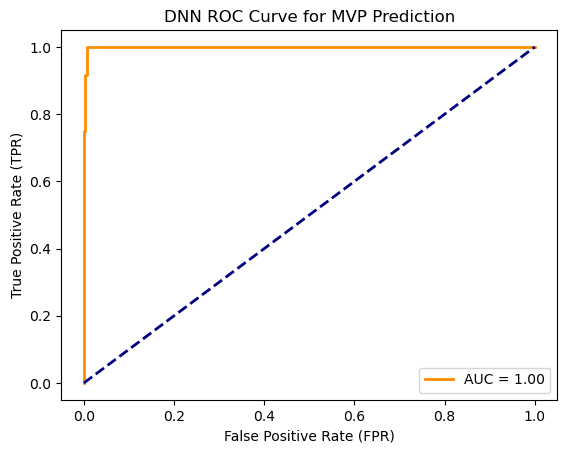

Area under curve (AUC):0.9990103908955963



In [53]:
## Plot AUC Curve ##

# Assign False positive rates, True positive rates and threholds from the ROC Curves
DNN_fprs, DNN_tprs, thresholds = roc_curve(y_test_class, DNN_proba_class)

# Determine AUC Score
DNN_roc_auc = roc_auc_score(y_test_class, DNN_proba_class)

# Plot Curve
plt.figure()
plt.plot(DNN_fprs, DNN_tprs, color='darkorange',
         lw=2, label='AUC = %0.2f' % DNN_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('DNN ROC Curve for MVP Prediction')
plt.legend(loc="best")
plt.show()

print(f'Area under curve (AUC):{DNN_roc_auc}')
print()

The Keras Classifier has a relatively high AUC score meaning at very low thresholds, the model perfoms well at ranking positive instances over negative instances. In comparison to the previous classsification models, this model has a much lower recall and precision score, so we will need to reduce threshold and capture more positive predictions to increase both recall and precision. 

To capture at least 1 MVP prediction since 2011 and improve recall score, we will need to set the model threshold to 0.006785 to generate predictions (0.006785 is the lowest probability from the last 12 years to predict the NBA MVP - Lebron James in 2012)

In [54]:
# Set Threshold
threshold = 0.006785 - 0.000001

# If the probability that a data point belongs to the positive class is greater than 0.101492, 
# it gets classified as 1; otherwise, it gets classified as 0
y_pred_DNN = np.where(DNN_proba_class > threshold, 1, 0)

DNN_threshold_class_report = classification_report(y_test_class, y_pred_DNN)
print(f"Classification report for a threshold of {threshold} \n")
print(DNN_threshold_class_report)

# Build a df
prob_DNN_class = pd.DataFrame(y_pred_DNN, columns=["MVP Prediction"], index=df_test.index)

# Add player and year columns
results_DNN_class = pd.concat([df_test[['Year','Player']], prob_DNN_class], axis=1)

# Filter out MVPs
results_DNN_class = results_DNN_class[results_DNN_class["MVP Prediction"] == 1]

# Add probabiltiies from model
results_DNN_class['Probability of MVP'] = DNN_proba_class_df.loc[results_DNN_class.index]

# Sort the dataframe based on Year and Probability
results_DNN_class.sort_values(["Year", "Probability of MVP"], axis = 0, ascending = True,
               inplace = True, na_position = "first")

# Preview df
results_DNN_class

Classification report for a threshold of 0.006784 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6063
           1       0.48      0.92      0.63        12

    accuracy                           1.00      6075
   macro avg       0.74      0.96      0.81      6075
weighted avg       1.00      1.00      1.00      6075



Year                 Player  MVP Prediction  Probability of MVP
12504  2011            Dwyane Wade               1            0.008130
12502  2011           LeBron James               1            0.011835
12373  2011              Pau Gasol               1            0.018424
12442  2011           Derrick Rose               1            0.149303
12863  2012           LeBron James               1            0.006785
13172  2013          Blake Griffin               1            0.006794
13171  2013             Chris Paul               1            0.008858
13552  2013           LeBron James               1            0.033024
13192  2013           Kevin Durant               1            0.073104
13758  2014          Blake Griffin               1            0.026860
13640  2014           Kevin Durant               1            0.054247
14360  2015             Chris Paul               1            0.015973
14474  2015          Stephen Curry               1            0.041348
14954  2016         Draymond Green               1            0.022377
14958  2016          Stephen Curry               1            0.167179
15183  2017           Kevin Durant               1            0.041491
15707  2018           James Harden               1            0.026401
16225  2019  Giannis Antetokounmpo               1            0.105797
16590  2020           LeBron James               1            0.009361
16856  2020       Montrezl Harrell               1            0.016649
17091  2020  Giannis Antetokounmpo               1            0.084781
17327  2021           Nikola Jokić               1            0.011983
17965  2022           Nikola Jokić               1            0.008328

We have increased precision to **0.48** and recall to **0.92** with the lower threshold - this is a higher recall vs previous classification models, however, the threshold is much lower for this model than previous models. We will be assessing and comparing all 3 models perfomance using the same threshold in the next section.

## Scikit Learn / Neural Network Model Results & Summary  <a id="3"></a>

For this project, ML pipelines were develop and the following models were developed for NBA MVP predictions:
- **Random Forest Regressor** --> Max_depth = 9, N_estimators = 50
- **XGB Classifier** --> Max_depth = 2, Learning_Rate = 0.1, N_estimators = 50
- **XGB Classifier (Upsampled)** --> Max_depth = 7, Learning_Rate = 0.7, N_estimators = 50
- **Keras Regressor** --> Units = 100, Dropout = 0.1, Epochs = 100, Learning Rate = 0.0001
- **Keras Classifier** --> Units = 100, Dropout = 0.1, Epochs = 100, Learning Rate = 0.0001


As we can see, there are various hyperparameter values across the different models. To explore the model performance, let us compare the model predictions and key metrisc i.e precision, recall, f1-score acrosst he models.

In [55]:
# Collect true results
true_results = df_test[df_test['Rank'] == 1][['Year','Player']]

#define list of DataFrames
dfs = [true_results, reg_results_df[['Year','Player']], 
       results_df_class[['Year','Player']], results_df_up_class[['Year','Player']],
       DNN_results_df[['Year','Player']], DNN_results_df_class[['Year','Player']]]

#merge all DataFrames into one
final_df = reduce(lambda  left,right: pd.merge(left,right,on=['Year'], how='outer'), dfs)
final_df.columns = ['Year','True MVPs', 'XGB Regressor', 
                    'XGB Classifier', 'XGB Classifier (upsampled)',
                   'Keras Regressor', 'Keras Classifier']

#set index
final_df = final_df.set_index('Year')
display(final_df)

True MVPs          XGB Regressor         XGB Classifier  \
Year                                                                        
2011           Derrick Rose           LeBron James           LeBron James   
2012           LeBron James           LeBron James           LeBron James   
2013           LeBron James           LeBron James           LeBron James   
2014           Kevin Durant           Kevin Durant           Kevin Durant   
2015          Stephen Curry          Stephen Curry          Stephen Curry   
2016          Stephen Curry          Stephen Curry          Stephen Curry   
2017      Russell Westbrook           James Harden          Kawhi Leonard   
2018           James Harden           James Harden           James Harden   
2019  Giannis Antetokounmpo  Giannis Antetokounmpo  Giannis Antetokounmpo   
2020  Giannis Antetokounmpo           James Harden           LeBron James   
2021           Nikola Jokić           Nikola Jokić           Nikola Jokić   
2022           Nikola Jokić  Giannis Antetokounmpo           Nikola Jokić   

     XGB Classifier (upsampled)        Keras Regressor       Keras Classifier  
Year                                                                           
2011               LeBron James           Derrick Rose           Derrick Rose  
2012               LeBron James           LeBron James           LeBron James  
2013               LeBron James           LeBron James           Kevin Durant  
2014               Kevin Durant           Kevin Durant           Kevin Durant  
2015                 Chris Paul          Stephen Curry          Stephen Curry  
2016          Russell Westbrook          Stephen Curry          Stephen Curry  
2017               Kevin Durant      Russell Westbrook           Kevin Durant  
2018               James Harden        Naz Mitrou-Long           James Harden  
2019      Giannis Antetokounmpo           James Harden  Giannis Antetokounmpo  
2020      Giannis Antetokounmpo  Giannis Antetokounmpo  Giannis Antetokounmpo  
2021             Damian Lillard           Nikola Jokić           Nikola Jokić  
2022                 Chris Paul           Nikola Jokić           Nikola Jokić

Please see below accuracy on the 5 models generated in predicting the NBA MVP from the past 12 seasons based on the highest probability from each NBA Season:
- **Random Forest Regressor**: 67% accuracy
- **XGB Classifier**: 75% accuracy
- **XGB Classifier (upsampled)**: 50%
- **Keras Regressor**: 83%
- **Keras Classifier**: 83%

In the section below, we will compare the above models to determine the optimum regression and classification models.

### Regression Models Predictions  <a id="3.1"></a>

Although, XGB Regressor generated a high accuracy, 67%, the model significantly overfit (67% test accuracy, 94% train accuracy); on the other hand, the Keras Regressor perfomed better with a 95.6% train accuracy and 97.4% test accuracy. Therefore, for the regression models, the **Keras Regressor** generated the best model performance. <br>

Let us review the top 5 MVP predictions from the Keras Regressor and also explain the contributions of each feature to a predicted output from the model. 

In [56]:
# Concat Player information and predicted MVP Share (Target Variable)
Reg_predictor = pd.concat([df_test[['Year','Player']], DNN_predictions], axis=1)

# Group by Year and apply function to collect top 5 MVP Share votes / year
Reg_predictor = Reg_predictor.groupby(['Year']).\
                apply(lambda x : x.sort_values(by = 'Predicted MVP Votes', 
                                               ascending = False).head(5))

# Drop Additional 'Year' column
Reg_predictor.drop(columns='Year', inplace=True)

# Preview df
Reg_predictor

Player  Predicted MVP Votes
Year                                                  
2011 12442           Derrick Rose             0.476228
     12502           LeBron James             0.473206
     12378            Kobe Bryant             0.366235
     12365          Dwight Howard             0.267336
     12504            Dwyane Wade             0.218393
2012 12863           LeBron James             0.509477
     12728             Chris Paul             0.100453
     12862            Dwyane Wade             0.076986
     12958           Kevin Durant             0.065725
     13078           Derrick Rose             0.065667
2013 13552           LeBron James             1.015280
     13192           Kevin Durant             0.474605
     13171             Chris Paul             0.194379
     13244            Kobe Bryant             0.145200
     13426        Carmelo Anthony             0.123939
2014 13640           Kevin Durant             0.556014
     14014           LeBron James             0.514529
     13671             Kevin Love             0.339537
     13599          Stephen Curry             0.252545
     13751             Chris Paul             0.156975
2015 14474          Stephen Curry             0.567272
     14360             Chris Paul             0.390519
     14313           James Harden             0.336202
     14072          Anthony Davis             0.321754
     14049      Russell Westbrook             0.110198
2016 14958          Stephen Curry             0.835762
     14544           LeBron James             0.326576
     14889           Kevin Durant             0.314596
     14901      Russell Westbrook             0.282846
     14582          Kawhi Leonard             0.277807
2017 15107      Russell Westbrook             0.488348
     15072           James Harden             0.454750
     15183           Kevin Durant             0.451463
     15179          Stephen Curry             0.301708
     15017          Kawhi Leonard             0.235709
2018 15789        Naz Mitrou-Long             0.734303
     15707           James Harden             0.588292
     16038          Anthony Davis             0.200700
     15962           Kevin Durant             0.164347
     15524           LeBron James             0.151482
2019 16314           James Harden             0.581893
     16225  Giannis Antetokounmpo             0.525309
     16237            Joel Embiid             0.193747
     16544           Nikola Jokić             0.151597
     16107            Tyler Davis             0.104737
2020 17091  Giannis Antetokounmpo             0.626550
     16590           LeBron James             0.480497
     16673           James Harden             0.268685
     16857          Kawhi Leonard             0.134324
     16598          Anthony Davis             0.091396
2021 17327           Nikola Jokić             0.511134
     17212            Joel Embiid             0.229280
     17555           LeBron James             0.159014
     17412  Giannis Antetokounmpo             0.119473
     17578             Chris Paul             0.112599
2022 17965           Nikola Jokić             0.571570
     18233            Joel Embiid             0.426422
     17740  Giannis Antetokounmpo             0.338303
     18007             Chris Paul             0.119291
     17980            Luka Dončić             0.077531

Intrestingly, our last 3 MVP winners have been correctly predicted by our model and the players are either Power-Forwards or Centres which would fall into the "Big" category for player position. Given the transition from "Big" to "Small" ball, our model and actual MVP votes still value the importance of a traditional "Big" man on the court. <br>
<br> 
Let us evaluate the key features/metrics that influence the prediction of MVP votes adn increase the probabiltiy of winning the MVP.

### Feature Importance on Keras Regressor Model.

One of the objectives of this project is to define the key metrics that increase the probability of winning the NBA MVP. We have over 63 independent variables in this dataset that has been modelled to predict the MVP ranking. <br>

We will be utlizing the SHAP parameter on the Keras Regressor model to explain the the contributions from each feature on the model. But first, let us re-run the model with the final hyperparameters and then proceed with running the SHAP function.

In [57]:
# Scale the data
Scalar = StandardScaler()
X_train_scaled = Scalar.fit_transform(X_train)
X_test_scaled = Scalar.transform(X_test)

In [58]:
# Create a new sequential model
model_reg = keras.Sequential()

# Declare the hidden layers
model_reg.add(layers.Dense(100, activation="relu"))
model_reg.add(layers.Dropout(0.1))
model_reg.add(layers.BatchNormalization()) 

model_reg.add(layers.Dense(100, activation="relu"))
model_reg.add(layers.Dropout(0.1))
model_reg.add(layers.BatchNormalization()) 

model_reg.add(layers.Dense(100, activation="relu"))
model_reg.add(layers.Dropout(0.1))
model_reg.add(layers.BatchNormalization()) 


# Declare the output layer
model_reg.add(layers.Dense(1)) # For regression, we don't specify any activation function.

# Compile the model
model_reg.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.0001),
              loss='MeanSquaredError',
              metrics = ['accuracy'])

# Fit model
history = model_reg.fit(X_train_scaled, y_train_num, epochs=100, verbose=0)

/Users/husseinwarfa/opt/anaconda3/envs/Warfa2/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/husseinwarfa/opt/anaconda3/envs/Warfa2/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/husseinwarfa/opt/anacon

/Users/husseinwarfa/opt/anaconda3/envs/Warfa2/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/husseinwarfa/opt/anaconda3/envs/Warfa2/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/husseinwarfa/opt/anacon

In [59]:
# Load JS Visualization to notebook
shap.initjs()

X_train_sample = shap.kmeans(X_train_scaled, 10)

In [60]:
# use Kernel SHAP to explain test set predictions
explainer_reg = shap.KernelExplainer(model_reg.predict, X_train_sample, nsamples=100, link = "identity")
shap_values_reg = explainer_reg.shap_values(X_test_scaled)

1/1 [==============================] - 0s 171ms/step


  0%|          | 0/6075 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


662/662 [==============================] - 1s 2ms/step


1/1 [==============================] - 0s 27ms/step


662/662 [==============================] - 1s 2ms/step


1/1 [==============================] - 0s 23ms/step


662/662 [==============================] - 2s 2ms/step


1/1 [==============================] - 0s 26ms/step


662/662 [==============================] - 2s 2ms/step


1/1 [==============================] - 0s 28ms/step


662/662 [==============================] - 2s 2ms/step


1/1 [==============================] - 0s 29ms/step


662/662 [==============================] - 2s 3ms/step


1/1 [==============================] - 0s 27ms/step


662/662 [==============================] - 2s 2ms/step


1/1 [==============================] - 0s 29ms/step


662/662 [==============================] - 2s 3ms/step


1/1 [==============================] - 0s 30ms/step


662/662 [==============================] - 2s 2ms/step


1/1 [==============================] - 0s 25ms/step


662/662 [==============================] - 2s 3ms/step


1/1 [==============================] - 0s 26ms/step


662/662 [==============================] - 1s 2ms/step


1/1 [==============================] - 0s 30ms/step


662/662 [==============================] - 1s 2ms/step


1/1 [==============================] - 0s 25ms/step


662/662 [==============================] - 1s 2ms/step


1/1 [==============================] - 0s 24ms/step


662/662 [==============================] - 2s 4ms/step


1/1 [==============================] - 0s 26ms/step


662/662 [==============================] - 1s 2ms/step


1/1 [==============================] - 0s 28ms/step


662/662 [==============================] - 1s 2ms/step


1/1 [==============================] - 0s 26ms/step


662/662 [==============================] - 1s 2ms/step


1/1 [==============================] - 0s 27ms/step


662/662 [==============================] - 1s 2ms/step


1/1 [==============================] - 0s 25ms/step


662/662 [==============================] - 3s 4ms/step


1/1 [==============================] - 0s 24ms/step


662/662 [==============================] - 1s 2ms/step


1/1 [==============================] - 0s 23ms/step


662/662 [==============================] - 1s 2ms/step


1/1 [==============================] - 0s 23ms/step


662/662 [==============================] - 2s 2ms/step


1/1 [==============================] - 0s 24ms/step


662/662 [==============================] - 1s 2ms/step


1/1 [==============================] - 0s 24ms/step


662/662 [==============================] - 1s 2ms/step


1/1 [==============================] - 0s 23ms/step


662/662 [==============================] - 2s 3ms/step


1/1 [==============================] - 0s 22ms/step


662/662 [==============================] - 1s 2ms/step


1/1 [==============================] - 0s 22ms/step


662/662 [==============================] - 1s 2ms/step


1/1 [==============================] - 0s 55ms/step


662/662 [==============================] - 1s 2ms/step


1/1 [==============================] - 0s 36ms/step


662/662 [==============================] - 5s 8ms/step


1/1 [==============================] - 0s 35ms/step


662/662 [==============================] - 2s 3ms/step


1/1 [==============================] - 0s 29ms/step


662/662 [==============================] - 1s 2ms/step


1/1 [==============================] - 0s 26ms/step


662/662 [==============================] - 1s 2ms/step


1/1 [==============================] - 0s 27ms/step


662/662 [==============================] - 1s 2ms/step


1/1 [==============================] - 0s 23ms/step


662/662 [==============================] - 1s 2ms/step


1/1 [==============================] - 0s 39ms/step


662/662 [==============================] - 1s 2ms/step


1/1 [==============================] - 0s 46ms/step


662/662 [==============================] - 2s 2ms/step


1/1 [==============================] - 0s 24ms/step


662/662 [==============================] - 2s 3ms/step


1/1 [==============================] - 0s 24ms/step


662/662 [==============================] - 2s 2ms/step


1/1 [==============================] - 0s 25ms/step


662/662 [==============================] - 2s 3ms/step


1/1 [==============================] - 0s 29ms/step


662/662 [==============================] - 1s 2ms/step


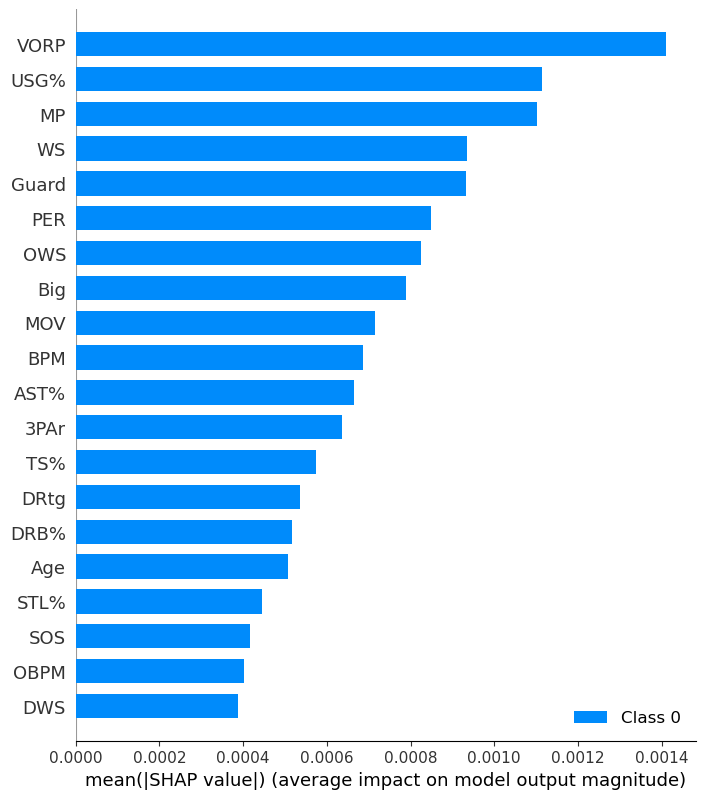

In [61]:
shap.summary_plot(shap_values_reg, X_test)

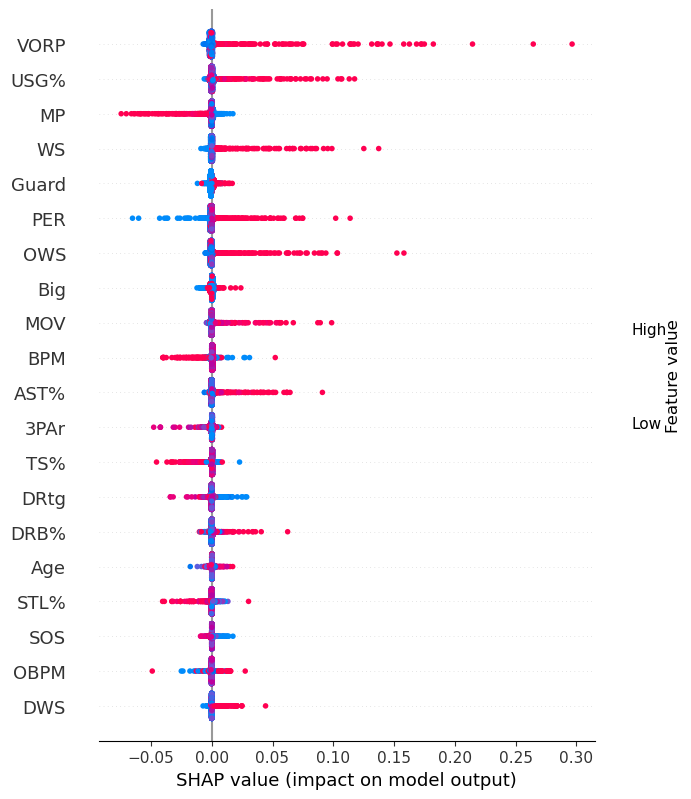

In [62]:
shap.summary_plot(shap_values_reg[0], X_test)

In [63]:
# For our 

### Classification Models Predictions <a id="3.2"></a>

For the 3 classification models, accuracy is not a suitable metric to evaluate model performance given the class imbalance. To evaluate model performance, the model thresholds were lowered to evaluate Precision, Recall and also AUC Score for the respectice models. 

First, let us evalaute the AUC curve for all 3 models.

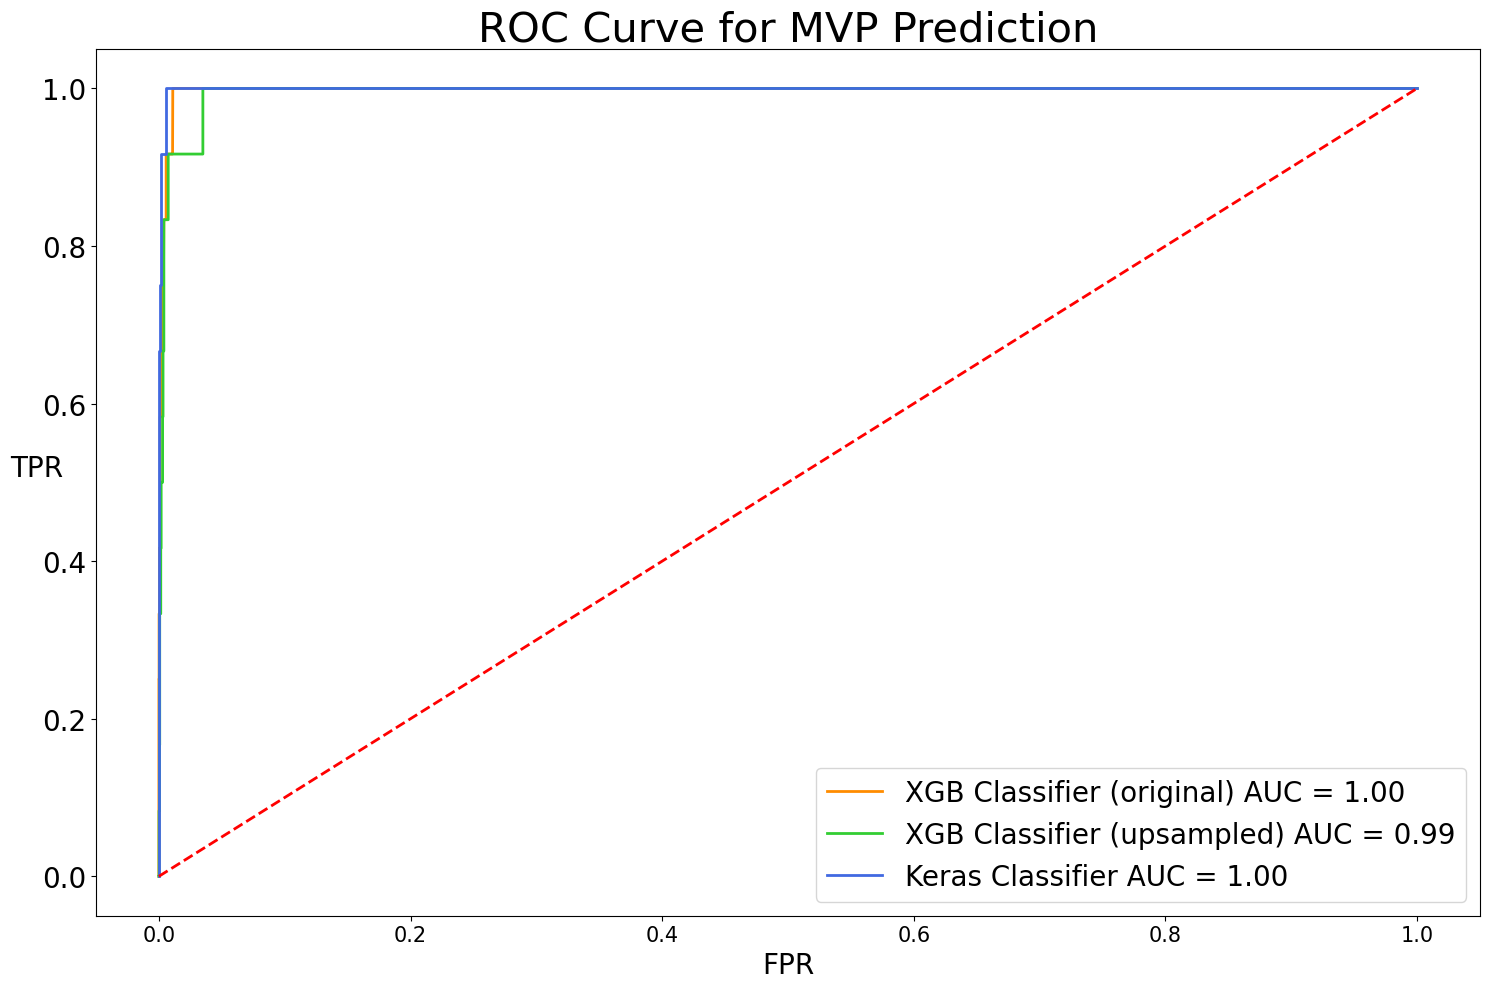

In [64]:
# Plot Curve
plt.figure(figsize=(15,10))
plt.plot(fprs, tprs, color='darkorange',
         lw=2, label='XGB Classifier (original) AUC = %0.2f' % roc_auc)
plt.plot(up_fprs, up_tprs, color='limegreen',
         lw=2, label='XGB Classifier (upsampled) AUC = %0.2f' % up_roc_auc)
plt.plot(DNN_fprs, DNN_tprs, color='royalblue',
         lw=2, label='Keras Classifier AUC = %0.2f' % DNN_roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlabel('FPR', fontsize=20)
plt.ylabel('TPR', fontsize=20, rotation=0)
plt.xticks(fontsize=15)
plt.yticks(fontsize=20)
plt.title('ROC Curve for MVP Prediction', fontsize=30)
plt.legend(loc="best", fontsize=20)
plt.savefig('data/ROC Curve for MVP Prediction(Advanced_Stats).png', facecolor = 'white', bbox_inches = 'tight')
plt.tight_layout()
plt.show()

print()

As you can seee from above, **XGB Classifer (original)** and **Keras Classifier** both had the highest AUC score, with the **Keras Classifier** slightly shading the **XGB Classifier**. We will need to explore running all 3 models at lower threshold to compare the precision, recall and f1-score to determine the optimum classification model. 

In [65]:
threshold = 0.006785

y_pred_class = np.where(proba_class > threshold, 1, 0)
class_report_new = classification_report(y_test_class, y_pred_class)
print(f"Classification report for a threshold of {threshold} on XGB Classifier.\n")
print(class_report_new)

y_pred_up_class = np.where(proba_up_class > threshold, 1, 0)
up_class_report_new = classification_report(y_test_class, y_pred_up_class)
print(f"Classification report for a threshold of {threshold} on XGB Classifier (upsampled)\n")
print(up_class_report_new)

print(f"Classification report for a threshold of {threshold} on Keras Classifier\n")
print(DNN_threshold_class_report)

Classification report for a threshold of 0.006785 on XGB Classifier.

              precision    recall  f1-score   support

           0       1.00      0.97      0.98      6063
           1       0.06      1.00      0.12        12

    accuracy                           0.97      6075
   macro avg       0.53      0.99      0.55      6075
weighted avg       1.00      0.97      0.98      6075

Classification report for a threshold of 0.006785 on XGB Classifier (upsampled)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6063
           1       0.26      0.50      0.34        12

    accuracy                           1.00      6075
   macro avg       0.63      0.75      0.67      6075
weighted avg       1.00      1.00      1.00      6075

Classification report for a threshold of 0.006785 on Keras Classifier

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6063
           1   

Based on the above charts, we can conclude the following:
- XGB Classifier generated the highest recall (**1**), however, the lowest precision (**0.06**) and F1-score (**0.12**) was recorded with this model. 
- Keras Classifier generated a relatively high recall (**0.92**), while recording the highest precision (**0.48**) and F1-score (**0.63**).
    - Additionally, this model has the highest AUC Score, meaning, at low thresholds, this model is the best model at distinguishing between positive and negative classes.

In summary, the **Keras Classifier** is the optimum classification model in predicting the NBA MVP as it had the best combination of recall, precision and AUC Score among the classification models and also correctly predicted 83% of the NBA MVPs - since 2011 - based on Model Probabilities.

Let us revisit model predictions from the Keras Classifier and actual NBA MVPs.

In [66]:
# Merge True MVP with Predicted MVPs from XGB Classifier model
new_df = pd.merge(final_df[['True MVPs']], results_DNN_class, on='Year')

# Rename 'Player' column
new_df.rename(columns = {'Player' : 'Predicted MVP Winners from Keras Classification Model @ 0.006785 threshold'}, 
              inplace=True)

#
new_df = new_df.groupby(['Year',
                         'True MVPs',
                         'Predicted MVP Winners from Keras Classification Model @ 0.006785 threshold'])\
                            .sum()[['Probability of MVP']].sort_values(["Year", "Probability of MVP"], 
                                          axis = 0, ascending = True,
                                          na_position = "first")

new_df

Probability of MVP
Year True MVPs             Predicted MVP Winners from Keras Classification...                    
2011 Derrick Rose          Dwyane Wade                                                   0.008130
                           LeBron James                                                  0.011835
                           Pau Gasol                                                     0.018424
                           Derrick Rose                                                  0.149303
2012 LeBron James          LeBron James                                                  0.006785
2013 LeBron James          Blake Griffin                                                 0.006794
                           Chris Paul                                                    0.008858
                           LeBron James                                                  0.033024
                           Kevin Durant                                                  0.073104
2014 Kevin Durant          Blake Griffin                                                 0.026860
                           Kevin Durant                                                  0.054247
2015 Stephen Curry         Chris Paul                                                    0.015973
                           Stephen Curry                                                 0.041348
2016 Stephen Curry         Draymond Green                                                0.022377
                           Stephen Curry                                                 0.167179
2017 Russell Westbrook     Kevin Durant                                                  0.041491
2018 James Harden          James Harden                                                  0.026401
2019 Giannis Antetokounmpo Giannis Antetokounmpo                                         0.105797
2020 Giannis Antetokounmpo LeBron James                                                  0.009361
                           Montrezl Harrell                                              0.016649
                           Giannis Antetokounmpo                                         0.084781
2021 Nikola Jokić          Nikola Jokić                                                  0.011983
2022 Nikola Jokić          Nikola Jokić                                                  0.008328

### Feature Importance on Keras Classifier Model.

One of the objectives of this project is to define the key metrics that increase the probability of winning the NBA MVP. We have over 63 independent variables in this dataset that has been modelled to predict the MVP ranking. <br>

We will be utlizing the SHAP parameter on the Keras Regressor model to explain the the contributions from each feature on the model. But first, let us re-run the model with the final hyperparameters and then proceed with running the SHAP function.

In [67]:
# Create a new sequential model
model_class = keras.Sequential()

# Declare the hidden layers
model_class.add(layers.Dense(100, activation="relu"))
model_class.add(layers.Dropout(0.1))
model_class.add(layers.BatchNormalization()) 

model_class.add(layers.Dense(100, activation="relu"))
model_class.add(layers.Dropout(0.1))
model_class.add(layers.BatchNormalization()) 

model_class.add(layers.Dense(100, activation="relu"))
model_class.add(layers.Dropout(0.1))
model_class.add(layers.BatchNormalization()) 


# Declare the output layer
model_class.add(layers.Dense(1, activation = "sigmoid"))

# Compile the model
model_class.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.01),
              loss = 'BinaryCrossentropy',
              metrics = ['accuracy'])

# Fit model
history_class = model_class.fit(X_train_scaled, y_train_class, epochs=100, verbose=0)

In [68]:
# use Kernel SHAP to explain test set predictions
explainer_class = shap.KernelExplainer(model_class.predict, X_train_sample, nsamples=100)
shap_values_class = explainer_class.shap_values(X_test_scaled)

1/1 [==============================] - 0s 183ms/step


  0%|          | 0/6075 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


662/662 [==============================] - 1s 2ms/step


1/1 [==============================] - 0s 24ms/step


662/662 [==============================] - 2s 3ms/step


1/1 [==============================] - 0s 39ms/step


662/662 [==============================] - 1s 2ms/step


1/1 [==============================] - 0s 26ms/step


662/662 [==============================] - 1s 2ms/step


1/1 [==============================] - 0s 33ms/step


662/662 [==============================] - 2s 2ms/step


1/1 [==============================] - 0s 39ms/step


662/662 [==============================] - 2s 2ms/step


1/1 [==============================] - 0s 27ms/step


662/662 [==============================] - 2s 2ms/step


1/1 [==============================] - 0s 27ms/step


662/662 [==============================] - 1s 2ms/step


1/1 [==============================] - 0s 23ms/step


662/662 [==============================] - 2s 2ms/step


1/1 [==============================] - 0s 23ms/step


662/662 [==============================] - 1s 2ms/step


1/1 [==============================] - 0s 23ms/step


662/662 [==============================] - 2s 3ms/step


1/1 [==============================] - 0s 28ms/step


662/662 [==============================] - 2s 2ms/step


1/1 [==============================] - 0s 24ms/step


662/662 [==============================] - 2s 2ms/step


1/1 [==============================] - 0s 24ms/step


662/662 [==============================] - 2s 3ms/step


1/1 [==============================] - 0s 28ms/step


662/662 [==============================] - 2s 2ms/step


1/1 [==============================] - 0s 25ms/step


662/662 [==============================] - 2s 3ms/step


1/1 [==============================] - 0s 24ms/step


662/662 [==============================] - 1s 2ms/step


1/1 [==============================] - 0s 25ms/step


662/662 [==============================] - 1s 2ms/step


1/1 [==============================] - 0s 22ms/step


662/662 [==============================] - 3s 4ms/step


1/1 [==============================] - 0s 23ms/step


662/662 [==============================] - 1s 2ms/step


1/1 [==============================] - 0s 28ms/step


662/662 [==============================] - 1s 2ms/step


1/1 [==============================] - 0s 25ms/step


662/662 [==============================] - 2s 2ms/step


1/1 [==============================] - 0s 23ms/step


662/662 [==============================] - 2s 3ms/step


1/1 [==============================] - 0s 24ms/step


662/662 [==============================] - 2s 2ms/step


1/1 [==============================] - 0s 27ms/step


662/662 [==============================] - 2s 3ms/step


1/1 [==============================] - 0s 27ms/step


662/662 [==============================] - 1s 2ms/step


1/1 [==============================] - 0s 26ms/step


662/662 [==============================] - 1s 2ms/step


1/1 [==============================] - 0s 29ms/step


662/662 [==============================] - 1s 2ms/step


1/1 [==============================] - 0s 24ms/step


662/662 [==============================] - 1s 2ms/step


1/1 [==============================] - 0s 23ms/step


662/662 [==============================] - 1s 2ms/step


1/1 [==============================] - 0s 30ms/step


662/662 [==============================] - 1s 2ms/step


1/1 [==============================] - 0s 25ms/step


662/662 [==============================] - 2s 3ms/step


1/1 [==============================] - 0s 36ms/step


662/662 [==============================] - 1s 2ms/step


1/1 [==============================] - 0s 28ms/step


662/662 [==============================] - 1s 2ms/step


1/1 [==============================] - 0s 27ms/step


662/662 [==============================] - 1s 2ms/step


1/1 [==============================] - 0s 33ms/step


662/662 [==============================] - 1s 2ms/step


1/1 [==============================] - 0s 25ms/step


662/662 [==============================] - 1s 2ms/step


1/1 [==============================] - 0s 23ms/step


662/662 [==============================] - 1s 2ms/step


1/1 [==============================] - 0s 27ms/step


662/662 [==============================] - 1s 2ms/step


1/1 [==============================] - 0s 23ms/step


662/662 [==============================] - 1s 2ms/step


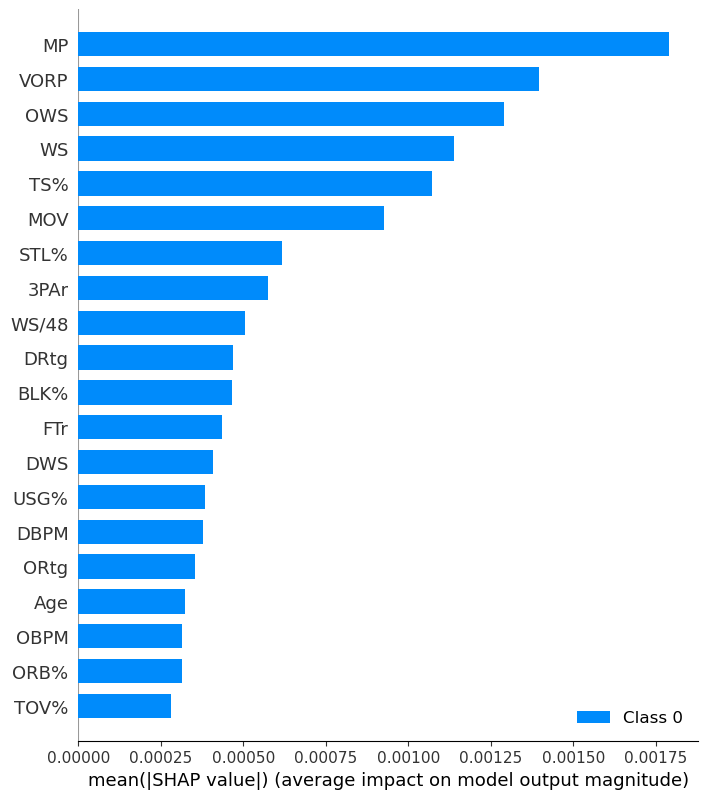

In [69]:
# Plot key features
shap.summary_plot(shap_values_class, X_test)

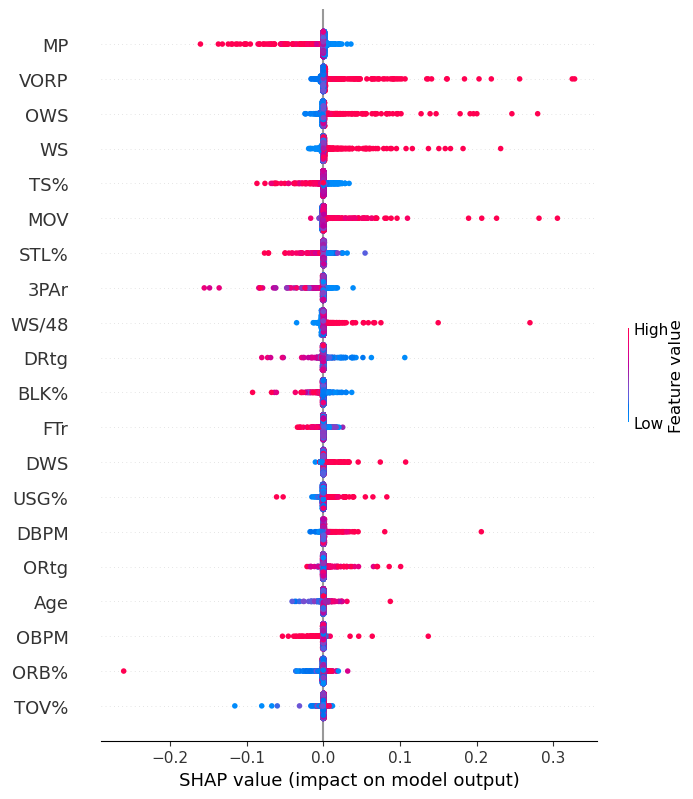

In [70]:
# Plot key features
shap.summary_plot(shap_values_class[0], X_test)

On the top classification model, the top 3 features in predicting the NBA MVP are **MP, WS and OWS**. PER appears as a top predictor on both models so this feature definitely has a significant influence on model predictions. 

## Conclusion <a id="5"></a>

In summary, the models performed really well in predicting the NBA MVP. The top regression and classification models were the Keras Regressor and Keras Classifier respectively. Valuable insights were generated from the model predictions and the top model features from the Keras Regressor were the **ORB%, PER and Age** and **MP, OWS and PER** on the Keras Classifier.

As a next step, I would look to explore the top features from the Keras Classifier and compare/contrast the differences between the 2 models. Additionally, I would look to explore dimensionality reduction i.e PCA for model improvement

In [71]:
# Save Keras Reg model
#joblib.dump(model_reg, "Models/keras_reg_model.h5")
model_reg.save('Models/keras_reg_model.h5')

# Save Keras Classifier model
#joblib.dump(model_class, "Models/keras_class_model.h5")
model_class.save('Models/keras_class_model.h5')

# Save Train Data
df_train.to_csv('data/df_train.csv')

# Save Test Data
df_test.to_csv('data/df_test.csv')

# Save scaled X-test data
X_test_df = pd.DataFrame(X_test_scaled)
X_test_df.to_csv('data/X_test_scaled.csv')